# Chapter 4.1

## Importing Libraries

In [1]:
from __future__ import absolute_import, division, print_function
from __future__ import unicode_literals

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import tqdm
from hfunc import models
from hfunc import metrics
import time

In [3]:
import tensorflow.keras as keras
from keras.backend import clear_session
import gc

# Reset Keras Session
def reset_keras():
    clear_session()
    print(gc.collect())
    print(gc.collect())

Using TensorFlow backend.


## Self-created functions

In [4]:
def estimate_node_importance(model, tester_model, layer_sizes, tol_low, tol_high, x, y):
    
    l, a = model.evaluate(x, y, verbose=0, batch_size=256)
    or_weights = model.get_weights()
    weight_len = len(or_weights) - 3
    num_zeros, num_worse, num_important = (0, 0, 0)
    z = []
    wr = []
    imp = []
    amounts = []
    places = []
    avg_imp = np.zeros(len(layer_sizes))
    avg_zero = np.zeros(len(layer_sizes))
    avg_wr = np.zeros(len(layer_sizes))
    for layer, size in enumerate(layer_sizes):
        num_zeros, num_worse, num_important = (0, 0, 0)
        z = []
        wr = []
        imp = []
        for i in range(size):
            w = copy.deepcopy(or_weights)
            w[weight_len - (2*layer+1)][...,i] = 0
            w[weight_len - 2*layer][i] = 0
            tester_model.set_weights(w)
            nl, na = tester_model.evaluate(x, y, verbose=0, batch_size=256)
            change = l - nl
            if change <= tol_high and change >= tol_low:
                num_zeros += 1
                z += [i]
                avg_zero[layer] += change
            elif change > 0:
                num_worse += 1
                wr += [i]
                avg_wr[layer] += change
            else:
                num_important += 1
                imp += [i]
                avg_imp[layer] += change
        amounts.append((num_zeros, num_worse, num_important))
        places.append((z, wr, imp))
        
        if num_important > 0:
            avg_imp[layer] /= num_important
        if num_zeros > 0:
            avg_zero[layer] /= num_zeros
        if num_worse > 0:
            avg_wr[layer] /= num_worse
    
    return amounts, places, avg_imp, avg_zero, avg_wr

In [5]:
def node_pruning(model, tester_model, x, y, layer_sizes, tol, ignore_cutoff, method='exhaustive'):

    loss, acc = model.evaluate(x, y, verbose=0, batch_size=256)
    original = model.get_weights()
    weight_len = len(original) - 3
    bas = [acc]
    bls = [loss]
    best_weights = model.get_weights()
    best_acc = 0
    best_loss = 1e20
    ol = loss
    oa = acc
    amounts = []
    places = []

    for layer, size in enumerate(layer_sizes):
        end_not_reached = True
        num_removed = 0
        nodes_removed = []
        if method == 'exhaustive':
            current_pos = 0
            best_change = tol
            best_pos = -1
            improved = False
            while end_not_reached or improved:
                if not(end_not_reached):
                    end_not_reached = True
                    improved = False
                    current_pos = 0
                    size -= 1
                    nodes_removed += [best_pos]
                    best_weights[weight_len - (2*layer+1)][...,best_pos] = 0
                    best_weights[weight_len - 2*layer][best_pos] = 0
                    best_pos = -1
                    ol = best_loss
                    oa = best_acc
                    bas += [best_acc]
                    bls += [best_loss]
                    best_change = tol
                    num_removed += 1
                if current_pos in nodes_removed:
                    current_pos += 1
                    if current_pos - num_removed >= size:
                        end_not_reached = False
                    continue
                w = copy.deepcopy(best_weights)
                w[weight_len - (2*layer+1)][...,current_pos] = 0
                w[weight_len - 2*layer][current_pos] = 0
                tester_model.set_weights(w)
                nl, na = tester_model.evaluate(x, y, verbose=0, batch_size=256)
                if ol - nl >= best_change:
                    best_change = ol - nl
                    best_pos = current_pos
                    improved = True
                    best_acc = na
                    best_loss = nl
                current_pos += 1
                if current_pos - num_removed >= size:
                    end_not_reached = False
        elif method == 'greedy':
            nodes_to_estimate = list(np.arange(size))
            current_pos = nodes_to_estimate[0]
            idx = 0
            while end_not_reached:
                w = copy.deepcopy(best_weights)
                w[weight_len - (2*layer+1)][...,current_pos] = 0
                w[weight_len - 2*layer][current_pos] = 0
                tester_model.set_weights(w)
                nl, na = tester_model.evaluate(x, y, verbose=0, batch_size=256)
                if ol - nl >= tol:
                    oa = na
                    ol = nl
                    size -= 1
                    nodes_removed += [current_pos]
                    nodes_to_estimate.remove(current_pos)
                    best_weights[weight_len - (2*layer+1)][..., current_pos] = 0
                    best_weights[weight_len - 2*layer][current_pos] = 0
                    bas += [oa]
                    bls += [ol]
                    num_removed += 1
                    idx = 0
                elif ol - nl <= ignore_cutoff:
                    size -= 1
                    nodes_to_estimate.remove(current_pos)
                else:
                    idx += 1
                if idx >= size:
                    end_not_reached = False
                else:
                    current_pos = nodes_to_estimate[idx]
        amounts.append(num_removed)
        places.append(nodes_removed)

    return best_weights, bas, bls, amounts, places

## Single-layer ANN

### MNIST

#### Set seed

In [54]:
np.random.seed(2020)

In [55]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [56]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [44]:
tester_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [58]:
trials = 25
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [128]
batch_sizes = [1, 8, 32, 256, 1024]
node_importance = np.zeros((trials, len(batch_sizes), len(layer_sizes), 3))
accs = np.zeros((trials, len(batch_sizes)))
losses = np.zeros((trials, len(batch_sizes)))
avg_node_imp = np.zeros((trials, len(batch_sizes), len(layer_sizes), 3))
for b, batch_size in enumerate(batch_sizes):
    for trial in tqdm.trange(trials):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape=(28, 28)),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(10, activation='softmax')
            ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(x_train, y_train, batch_size=batch_size, verbose=0, epochs=5)
        losses[trial, b], accs[trial, b] = model.evaluate(x_test, y_test, verbose=0)
        tmp_a, _, ai, az, aw = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
        for i, (nz, nw, ni) in enumerate(tmp_a):
            node_importance[trial, b, i, 0] = nz
            node_importance[trial, b, i, 1] = nw
            node_importance[trial, b, i, 2] = ni
            avg_node_imp[trial, b, i] = [az[i], aw[i], ai[i]]

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:02<00:00,  9.69s/it]


In [60]:
index = pd.MultiIndex.from_product([batch_sizes, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI = pd.DataFrame(node_importance[:, :, 0, :].reshape(trials, -1), columns=index)
NI.to_csv('../../../results/node_imp_ANN_batch_mnist.csv')
NI.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000   25.000000       25.000000  25.000000   25.000000   
mean    9.240000   28.680000       90.080000   4.320000   27.400000   
std     2.521243    4.871003        4.949074   2.193171    6.988085   
min     6.000000   20.000000       79.000000   0.000000   13.000000   
25%     7.000000   26.000000       87.000000   3.000000   22.000000   
50%     9.000000   28.000000       91.000000   4.000000   27.000000   
75%    11.000000   32.000000       94.000000   6.000000   32.000000   
max    14.000000   39.000000      100.000000  10.000000   42.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000   25.000000       25.000000  25.000000   
mean        96.280000   2.160000   25.720000      100.120000   2.200000   
std          6.380439   1.650253    5.184271        5.077073   1.258306   
min         86.000000   0.000000   15.000000       91.000000   0.000000   
25%         91.000000   1.000000   24.000000       97.000000   1.000000   
50%         97.000000   2.000000   25.000000      100.000000   2.000000   
75%        100.000000   2.000000   28.000000      103.000000   3.000000   
max        107.000000   6.000000   36.000000      111.000000   6.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  25.000000   25.000000       25.000000  
mean    13.520000      112.280000   2.840000    3.320000      121.840000  
std      5.067215        5.264029   1.178983    3.955165        4.298062  
min      5.000000      102.000000   0.000000    0.000000      110.000000  
25%      9.000000      108.000000   2.000000    0.000000      120.000000  
50%     12.000000      113.000000   3.000000    2.000000      123.000000  
75%     18.000000      116.000000   4.000000    5.000000      125.000000  
max     22.000000      121.000000   5.000000   14.000000      126.000000

In [69]:
idx = pd.IndexSlice
NI.loc[idx[:], idx[:,'Zero Nodes']]

,1,8,32,256,1024
,Zero Nodes,Zero Nodes,Zero Nodes,Zero Nodes,Zero Nodes
0,8.0,4.0,0.0,2.0,3.0
1,7.0,3.0,1.0,0.0,0.0
2,9.0,4.0,4.0,3.0,4.0
3,13.0,3.0,2.0,3.0,2.0
4,14.0,4.0,1.0,3.0,2.0
5,9.0,7.0,0.0,2.0,4.0
6,8.0,3.0,1.0,3.0,2.0
7,11.0,2.0,1.0,3.0,5.0
8,14.0,7.0,6.0,3.0,3.0


In [61]:
AvgNI = pd.DataFrame(avg_node_imp.reshape(trials, -1), columns=index)
AvgNI.to_csv('../../../results/node_imp_ANN_batch_mnist.csv')
AvgNI.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -2.108606e-07    0.001827       -0.004355  4.367935e-07    0.000979   
std    5.844582e-07    0.000625        0.000687  1.649005e-06    0.000378   
min   -2.071261e-06    0.000947       -0.005588 -2.580384e-06    0.000397   
25%   -3.405980e-08    0.001455       -0.005087 -9.579318e-09    0.000673   
50%    0.000000e+00    0.001766       -0.004216  0.000000e+00    0.001026   
75%    0.000000e+00    0.002142       -0.003941  1.067917e-06    0.001274   
max    7.574757e-07    0.003366       -0.003416  3.330410e-06    0.001806   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.002468  3.768702e-07    0.000731       -0.002508  4.509091e-07   
std          0.000509  2.297901e-06    0.000274        0.000330  1.649999e-06   
min         -0.003537 -7.808208e-06    0.000261       -0.003335 -2.831221e-06   
25%         -0.002954  0.000000e+00    0.000545       -0.002793 -3.054738e-07   
50%         -0.002308  0.000000e+00    0.000714       -0.002424  1.490116e-08   
75%         -0.002142  8.940697e-07    0.000893       -0.002236  1.301368e-06   
max         -0.001603  4.443030e-06    0.001370       -0.002024  3.837049e-06   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000605       -0.002722 -1.374682e-07    0.000270       -0.002731  
std      0.000215        0.000219  1.950560e-06    0.000270        0.000182  
min      0.000187       -0.003076 -5.811453e-06    0.000000       -0.003154  
25%      0.000463       -0.002857 -2.942979e-07    0.000000       -0.002816  
50%      0.000573       -0.002674  0.000000e+00    0.000219       -0.002732  
75%      0.000750       -0.002611  4.271666e-07    0.000538       -0.002589  
max      0.001026       -0.002325  3.404915e-06    0.000671       -0.002482

In [62]:
A = pd.DataFrame(accs, columns=batch_sizes)
A.to_csv('../../../results/avg_acc_ANN_batch_mnist.csv')
A.describe()

,1,8,32,256,1024
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.970360,0.975284,0.975012,0.965768,0.945492
std,0.002459,0.002261,0.001490,0.001068,0.001609
min,0.965400,0.968100,0.970900,0.963300,0.941500
25%,0.969000,0.974100,0.974300,0.965100,0.944600
50%,0.970400,0.975600,0.975400,0.965900,0.945400
75%,0.972300,0.976500,0.975800,0.966700,0.946300
max,0.974000,0.978900,0.977100,0.967200,0.948900


In [63]:
L = pd.DataFrame(losses, columns=batch_sizes)
L.to_csv('../../../results/loss_ANN_batch_mnist.csv')
L.describe()

,1,8,32,256,1024
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.174131,0.088501,0.081760,0.116011,0.191563
std,0.018014,0.008218,0.004363,0.002826,0.004553
min,0.147659,0.077100,0.073245,0.111124,0.184052
25%,0.163239,0.081233,0.078294,0.113715,0.187885
50%,0.169125,0.088578,0.081583,0.115573,0.191765
75%,0.173161,0.094862,0.084617,0.117663,0.194892
max,0.217958,0.107848,0.092457,0.122182,0.202363


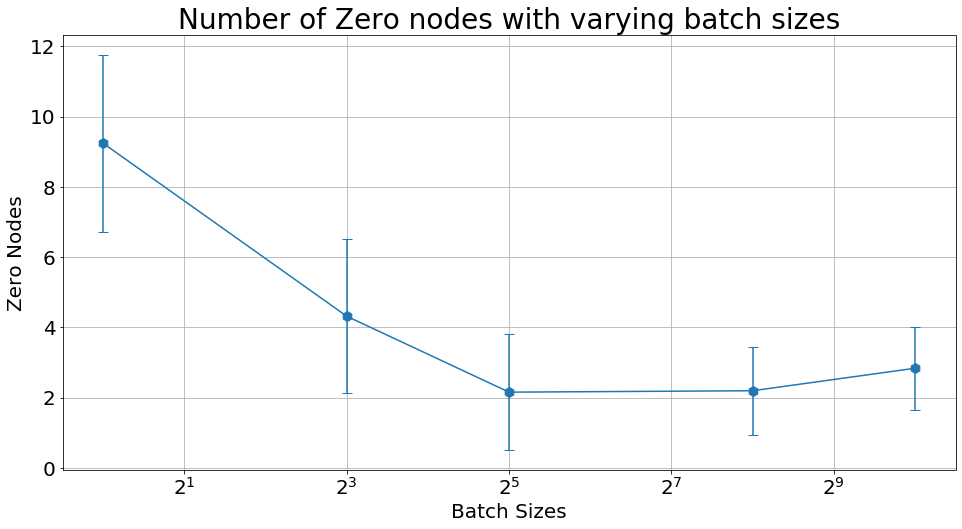

In [81]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Zero Nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Zero Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/zero_nodes_ANN_batch_mnist.png")

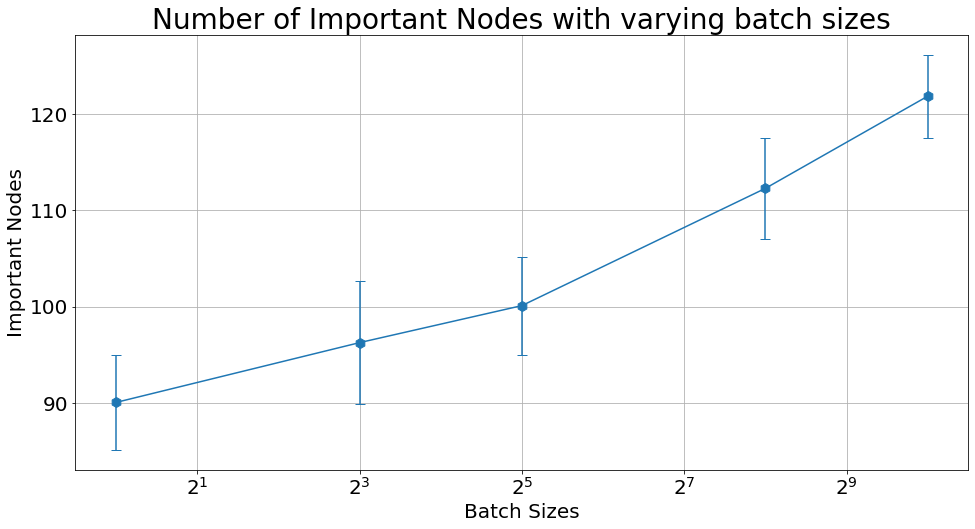

In [82]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Important Nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Important Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/imp_nodes_ANN_batch_mnist.png")

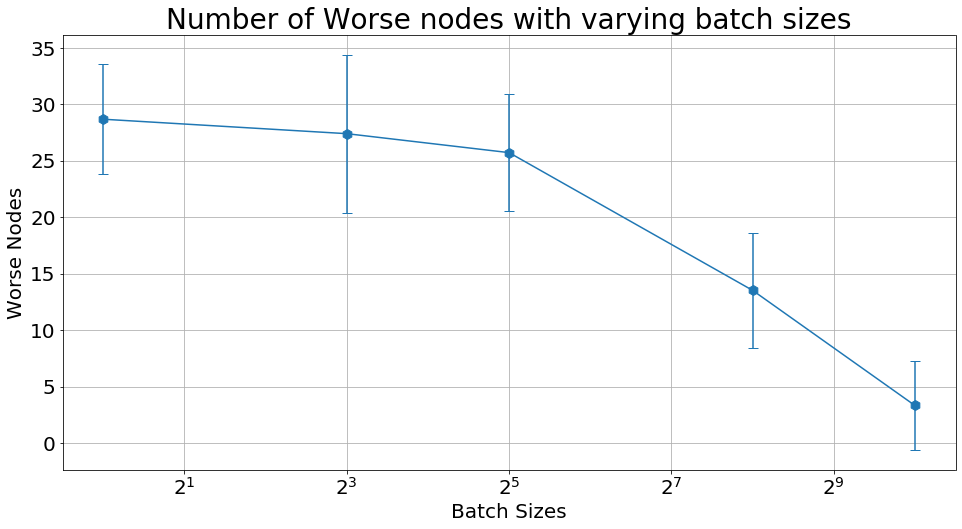

In [83]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Worse nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Worse Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/worse_nodes_ANN_batch_mnist.png")

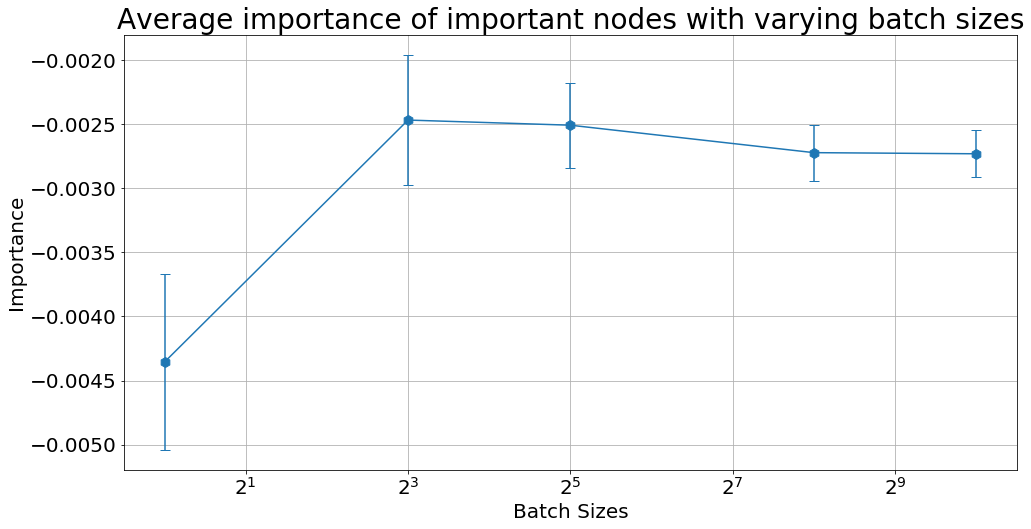

In [84]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = AvgNI.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
stdz= AvgNI.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Average importance of important nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/avg_imp_nodes_ANN_batch_mnist.png")

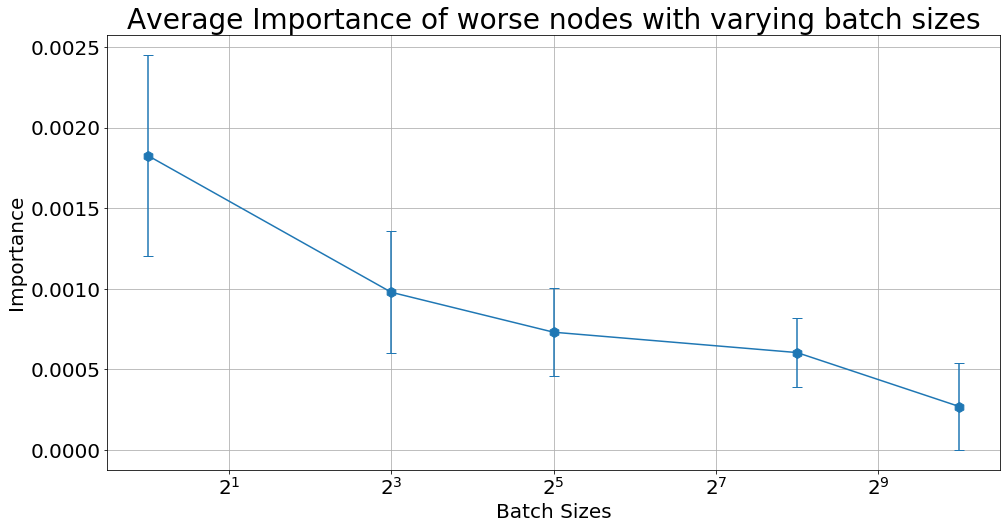

In [85]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = AvgNI.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
stdz= AvgNI.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Average Importance of worse nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/avg_worse_nodes_ANN_batch_mnist.png")

### Fashion MNIST

## Set seed

In [86]:
np.random.seed(2020)

In [87]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [88]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [44]:
tester_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [89]:
trials = 25
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [128]
batch_sizes = [1, 8, 32, 256, 1024]
node_importance = np.zeros((trials, len(batch_sizes), len(layer_sizes), 3))
avg_node_imp = np.zeros((trials, len(batch_sizes), len(layer_sizes), 3))
accs = np.zeros((trials, len(batch_sizes)))
losses = np.zeros((trials, len(batch_sizes)))
for b, batch_size in enumerate(batch_sizes):
    for trial in tqdm.trange(trials):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape=(28, 28)),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(10, activation='softmax')
            ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(x_train, y_train, batch_size=batch_size, verbose=0, epochs=5)
        losses[trial, b], accs[trial, b] = model.evaluate(x_test, y_test, verbose=0)
        tmp_a, _, ai, az, aw = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
        for i, (nz, nw, ni) in enumerate(tmp_a):
            node_importance[trial, b, i, 0] = nz
            node_importance[trial, b, i, 1] = nw
            node_importance[trial, b, i, 2] = ni
            avg_node_imp[trial, b, i] = [az[i], aw[i], ai[i]]

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:04<00:00,  9.78s/it]


In [90]:
index = pd.MultiIndex.from_product([batch_sizes, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI = pd.DataFrame(node_importance[:, :, 0, :].reshape(trials, -1), columns=index)
NI.to_csv('../../../results/node_imp_ANN_batch_fmnist.csv')
NI.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count   25.00000   25.000000       25.000000  25.000000    25.00000   
mean    55.28000   24.880000       47.840000  28.240000    23.88000   
std      4.75675    5.182663        5.233546   3.821867     5.38764   
min     43.00000   15.000000       37.000000  20.000000    17.00000   
25%     53.00000   22.000000       44.000000  27.000000    19.00000   
50%     54.00000   25.000000       49.000000  28.000000    22.00000   
75%     56.00000   28.000000       52.000000  30.000000    27.00000   
max     63.00000   35.000000       55.000000  36.000000    34.00000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count        25.00000  25.000000    25.00000       25.000000  25.000000   
mean         75.88000  14.800000    26.68000       86.520000  10.560000   
std           5.47205   4.020779     4.33705        5.244998   3.228519   
min          66.00000   6.000000    19.00000       73.000000   5.000000   
25%          72.00000  12.000000    23.00000       85.000000   8.000000   
50%          77.00000  15.000000    26.00000       88.000000  11.000000   
75%          81.00000  18.000000    30.00000       89.000000  12.000000   
max          85.00000  22.000000    34.00000       94.000000  16.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count        25.0        25.00000  25.000000   25.000000            25.0  
mean         27.2        90.24000  12.560000   13.040000           102.4  
std           8.5         8.86604   2.973214    5.841518             6.0  
min           9.0        76.00000   8.000000    1.000000            93.0  
25%          21.0        84.00000  11.000000   11.000000            98.0  
50%          28.0        87.00000  13.000000   13.000000           103.0  
75%          33.0        96.00000  14.000000   15.000000           107.0  
max          41.0       110.00000  19.000000   24.000000           112.0

In [91]:
AvgNI = pd.DataFrame(avg_node_imp.reshape(trials, -1), columns=index)
AvgNI.to_csv('../../../results/avg_node_imp_ANN_batch_fmnist.csv')
AvgNI.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -5.321162e-09    0.001964       -0.012145 -1.889830e-07    0.001647   
std    1.691529e-07    0.000974        0.002596  4.434091e-07    0.000824   
min   -3.199532e-07    0.000700       -0.017479 -1.096520e-06    0.000335   
25%   -1.112265e-07    0.001175       -0.013684 -4.708767e-07    0.001233   
50%    0.000000e+00    0.001672       -0.011948 -2.071971e-07    0.001498   
75%    6.567549e-08    0.002847       -0.010797  1.057502e-07    0.001785   
max    3.292117e-07    0.004217       -0.008059  7.331371e-07    0.003655   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.003984 -3.006769e-07    0.001590       -0.003162 -9.951838e-08   
std          0.000588  4.964413e-07    0.000732        0.000432  5.264181e-07   
min         -0.005437 -1.279207e-06    0.000441       -0.004537 -1.110137e-06   
25%         -0.004190 -7.119444e-07    0.001132       -0.003303 -4.358590e-07   
50%         -0.003939 -1.929308e-07    0.001529       -0.003071 -9.313226e-09   
75%         -0.003622  4.199418e-08    0.001862       -0.002875  2.430036e-07   
max         -0.003014  4.540471e-07    0.003575       -0.002707  9.357929e-07   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.003764       -0.007505 -1.157520e-07    0.001658       -0.007572  
std      0.002292        0.001846  4.709704e-07    0.000902        0.000677  
min      0.000934       -0.010912 -1.002103e-06    0.000618       -0.009157  
25%      0.001852       -0.008949 -4.559755e-07    0.001049       -0.008106  
50%      0.002802       -0.006894 -4.304780e-08    0.001355       -0.007405  
75%      0.005466       -0.006253  2.086163e-07    0.002028       -0.007070  
max      0.008054       -0.004723  7.390976e-07    0.003717       -0.006613

In [92]:
A = pd.DataFrame(accs, columns=batch_sizes)
A.to_csv('../../../results/acc_ANN_batch_fmnist.csv')
A.describe()

,1,8,32,256,1024
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.852048,0.868368,0.870284,0.857128,0.844328
std,0.005221,0.005418,0.004017,0.006844,0.002261
min,0.843500,0.852600,0.861900,0.840300,0.838200
25%,0.849400,0.865700,0.867600,0.854100,0.843000
50%,0.850800,0.869800,0.869700,0.858200,0.844600
75%,0.855400,0.871900,0.874100,0.862100,0.846200
max,0.863600,0.875200,0.879300,0.866600,0.848000


In [93]:
L = pd.DataFrame(losses, columns=batch_sizes)
L.to_csv('../../../results/loss_ANN_batch_fmnist.csv')
L.describe()

,1,8,32,256,1024
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.472010,0.373053,0.358983,0.401171,0.444528
std,0.023108,0.016811,0.008317,0.016099,0.004017
min,0.443326,0.349747,0.338773,0.380672,0.438190
25%,0.455713,0.360416,0.356645,0.390062,0.440692
50%,0.461411,0.369488,0.359884,0.396469,0.445194
75%,0.486305,0.380492,0.361079,0.407553,0.447605
max,0.533597,0.418937,0.378775,0.440649,0.453020


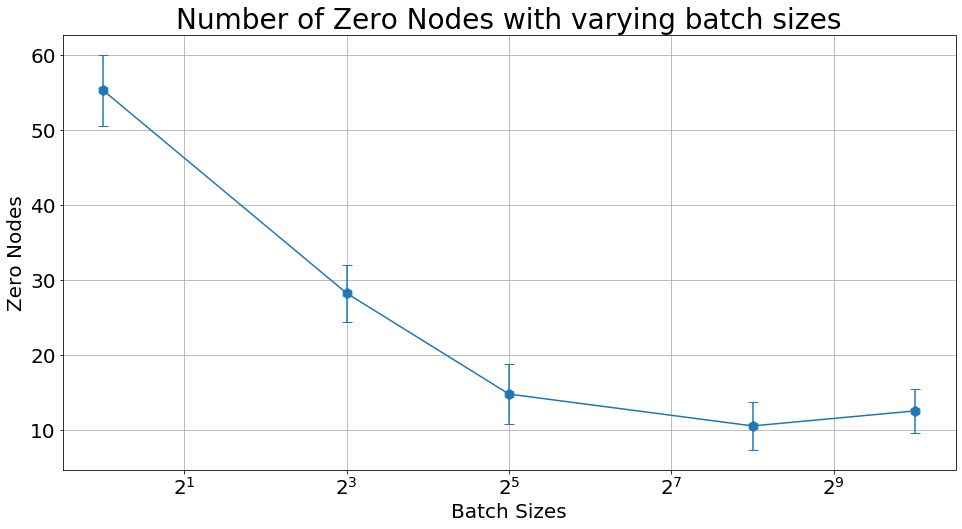

In [94]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Zero Nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Zero Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/zero_nodes_ANN_batch_fmnist.png")

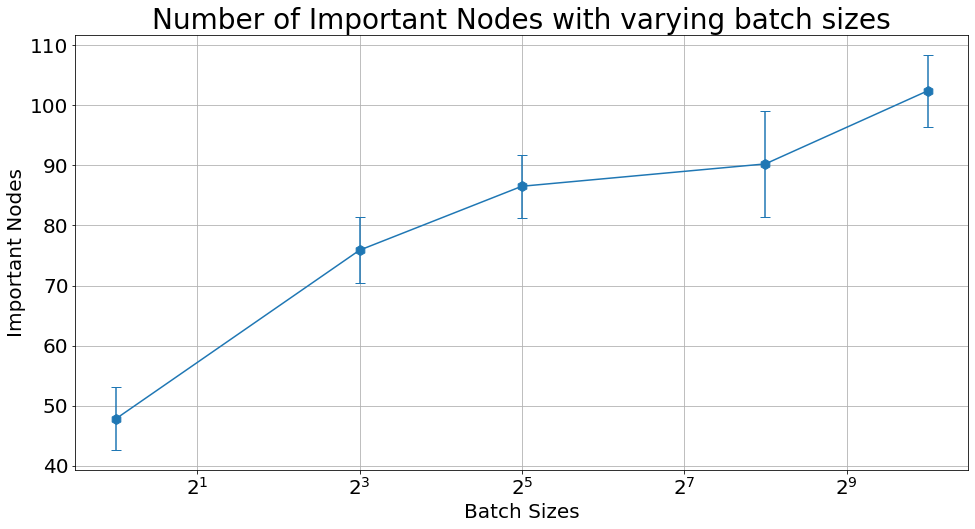

In [95]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Important Nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Important Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/imp_nodes_ANN_batch_fmnist.png")

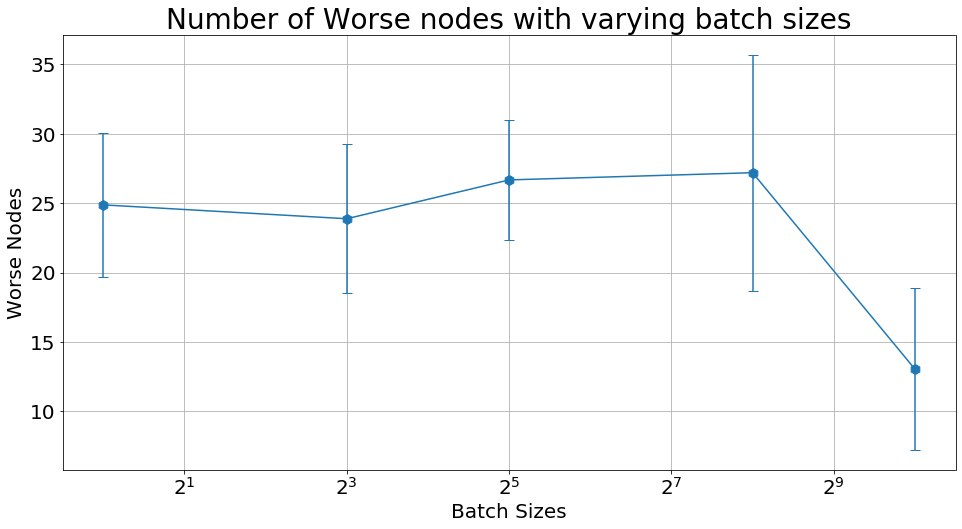

In [96]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Worse nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Worse Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/worse_nodes_ANN_batch_fmnist.png")

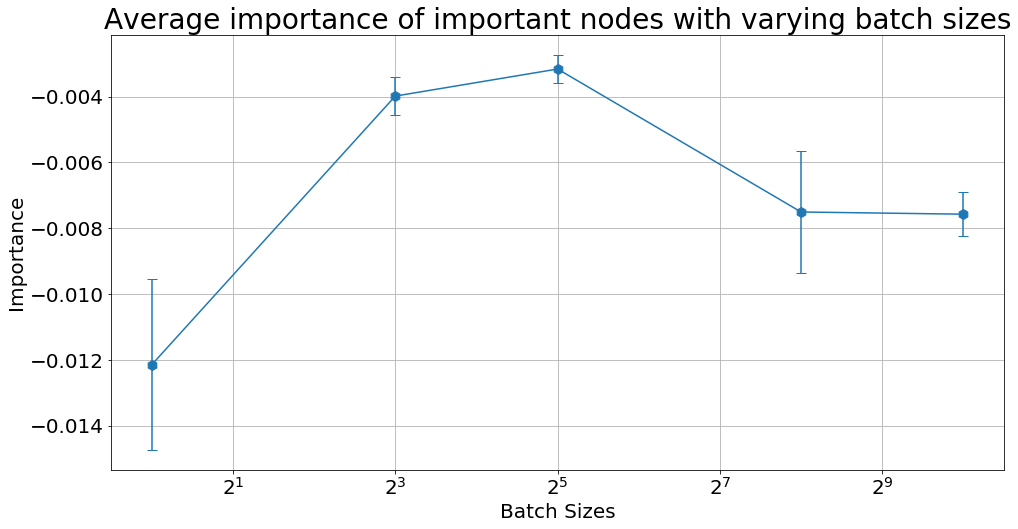

In [97]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = AvgNI.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
stdz= AvgNI.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Average importance of important nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/avg_imp_nodes_ANN_batch_fmnist.png")

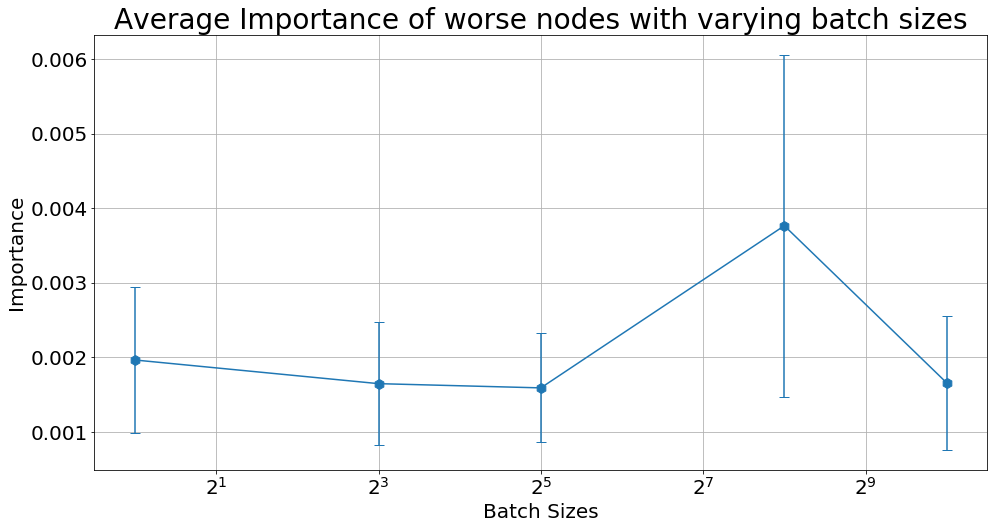

In [98]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = AvgNI.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
stdz= AvgNI.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Average Importance of worse nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/avg_worse_nodes_ANN_batch_fmnist.png")

## Multi-layer Perceptron

### MNIST

#### Set seed

In [103]:
np.random.seed(2020)

In [104]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [105]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [106]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [107]:
trials = 25
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [32, 64, 128]
batch_sizes = [1, 8, 32, 256, 1024]
node_importance = np.zeros((trials, len(batch_sizes), len(layer_sizes), 3))
avg_node_imp = np.zeros((trials, len(batch_sizes), len(layer_sizes), 3))
accs = np.zeros((trials, len(batch_sizes)))
losses = np.zeros((trials, len(batch_sizes)))
for b, batch_size in enumerate(batch_sizes):
    for trial in tqdm.trange(trials):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(x_train, y_train, batch_size=batch_size, verbose=0, epochs=5)
        losses[trial, b], accs[trial, b] = model.evaluate(x_test, y_test, verbose=0)
        tmp_a, _, ai, az, aw = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
        for i, (nz, nw, ni) in enumerate(tmp_a):
            node_importance[trial, b, i, 0] = nz
            node_importance[trial, b, i, 1] = nw
            node_importance[trial, b, i, 2] = ni
            avg_node_imp[trial, b, i] = [az[i], aw[i], ai[i]]

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [06:57<00:00, 16.70s/it]


In [108]:
index = pd.MultiIndex.from_product([batch_sizes, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])

In [109]:
NI_1 = pd.DataFrame(node_importance[:, :, 2, :].reshape(trials, -1), columns=index)
NI_1.to_csv('../../../results/node_imp_MLP_l1_batch_mnist.csv')
NI_1.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000   25.000000       25.000000  25.000000   25.000000   
mean   15.000000   41.880000       71.120000   5.440000   29.800000   
std     3.265986    8.038035        8.800189   2.501333    5.131601   
min     9.000000   20.000000       56.000000   2.000000   21.000000   
25%    14.000000   36.000000       65.000000   3.000000   26.000000   
50%    14.000000   44.000000       70.000000   5.000000   29.000000   
75%    17.000000   49.000000       75.000000   7.000000   32.000000   
max    21.000000   54.000000       89.000000  11.000000   41.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000    25.00000       25.000000  25.000000   
mean        92.760000   3.360000    32.52000       92.120000   1.200000   
std          5.109468   1.604161     5.80316        6.036831   1.154701   
min         83.000000   0.000000    19.00000       80.000000   0.000000   
25%         91.000000   2.000000    30.00000       88.000000   0.000000   
50%         92.000000   3.000000    32.00000       92.000000   1.000000   
75%         97.000000   5.000000    36.00000       95.000000   2.000000   
max        102.000000   6.000000    45.00000      107.000000   4.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  25.000000   25.000000       25.000000  
mean    23.200000      103.600000   2.520000    9.800000      115.680000  
std      7.735201        7.863417   1.873499    5.678908        5.610407  
min      8.000000       92.000000   0.000000    1.000000      104.000000  
25%     16.000000       98.000000   1.000000    5.000000      112.000000  
50%     25.000000      102.000000   2.000000   10.000000      115.000000  
75%     28.000000      110.000000   3.000000   13.000000      119.000000  
max     35.000000      119.000000   7.000000   23.000000      125.000000

In [110]:
AvgNI_1 = pd.DataFrame(avg_node_imp[:, :, 2, :].reshape(trials, -1), columns=index)
AvgNI_1.to_csv('../../../results/avg_node_imp_MLP_l1_batch_mnist.csv')
AvgNI_1.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -5.367757e-08    0.003601       -0.300885  2.785238e-07    0.001129   
std    3.656608e-07    0.001368        0.344872  1.453596e-06    0.000626   
min   -8.063184e-07    0.001413       -1.361422 -2.764165e-06    0.000366   
25%   -2.185504e-07    0.002288       -0.322339 -7.418650e-07    0.000809   
50%    0.000000e+00    0.003730       -0.217259  1.458185e-07    0.000938   
75%    0.000000e+00    0.004622       -0.053513  9.365380e-07    0.001283   
max    8.404255e-07    0.006605       -0.022302  2.987683e-06    0.003483   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.003123  3.773272e-07    0.001103       -0.003174  6.239365e-07   
std          0.000826  1.759174e-06    0.000438        0.000703  1.781299e-06   
min         -0.005181 -3.356487e-06    0.000338       -0.004811 -3.475696e-06   
25%         -0.003233  0.000000e+00    0.000754       -0.003541  0.000000e+00   
50%         -0.002941  0.000000e+00    0.001142       -0.003031  0.000000e+00   
75%         -0.002672  9.946525e-07    0.001299       -0.002772  1.057982e-06   
max         -0.002151  5.044043e-06    0.001870       -0.002042  6.362796e-06   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.001244       -0.003937 -1.852569e-07    0.000739       -0.004543  
std      0.000628        0.000647  1.930562e-06    0.000409        0.000464  
min      0.000379       -0.005969 -5.081296e-06    0.000076       -0.005711  
25%      0.000766       -0.004339 -9.834766e-07    0.000389       -0.004701  
50%      0.001207       -0.003833 -5.960464e-08    0.000677       -0.004549  
75%      0.001573       -0.003526  0.000000e+00    0.001025       -0.004345  
max      0.002835       -0.003047  4.306436e-06    0.001695       -0.003694

In [111]:
NI_2 = pd.DataFrame(node_importance[:, :, 1, :].reshape(trials, -1), columns=index)
NI_2.to_csv('../../../results/node_imp_MLP_l2_batch_mnist.csv')
NI_2.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000   25.000000       25.000000  25.000000   25.000000   
mean   11.800000   21.920000       30.280000   1.000000   21.240000   
std     3.316625    3.957272        3.680127   1.080123    3.282276   
min     7.000000   13.000000       24.000000   0.000000   16.000000   
25%     9.000000   19.000000       28.000000   0.000000   19.000000   
50%    11.000000   22.000000       30.000000   1.000000   21.000000   
75%    14.000000   25.000000       34.000000   1.000000   23.000000   
max    18.000000   28.000000       37.000000   3.000000   28.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000   25.000000       25.000000  25.000000   
mean        41.760000   1.440000   17.200000       45.360000   4.480000   
std          3.357578   1.083205    5.275731        5.227173   2.347339   
min         35.000000   0.000000    6.000000       33.000000   1.000000   
25%         38.000000   1.000000   14.000000       42.000000   3.000000   
50%         43.000000   1.000000   16.000000       46.000000   4.000000   
75%         43.000000   2.000000   20.000000       48.000000   6.000000   
max         47.000000   3.000000   31.000000       57.000000   9.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  25.000000   25.000000       25.000000  
mean     5.720000       53.800000   5.040000    1.040000       57.920000  
std      3.102687        3.662877   2.169485    1.767295        2.307957  
min      1.000000       46.000000   1.000000    0.000000       52.000000  
25%      3.000000       52.000000   3.000000    0.000000       57.000000  
50%      6.000000       53.000000   5.000000    1.000000       58.000000  
75%      8.000000       56.000000   6.000000    1.000000       59.000000  
max     13.000000       61.000000  11.000000    7.000000       62.000000

In [112]:
AvgNI_2 = pd.DataFrame(avg_node_imp[:, :, 1, :].reshape(trials, -1), columns=index)
AvgNI_2.to_csv('../../../results/avg_node_imp_MLP_l2_batch_mnist.csv')
AvgNI_2.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -2.533785e-07    0.002999       -0.039972 -1.575053e-07    0.001545   
std    5.358682e-07    0.001322        0.021823  3.069925e-06    0.000830   
min   -1.935495e-06    0.000886       -0.085308 -9.693205e-06    0.000313   
25%   -4.837910e-07    0.001825       -0.050629 -2.533197e-07    0.001009   
50%   -2.709302e-08    0.003152       -0.035435  0.000000e+00    0.001377   
75%    0.000000e+00    0.003783       -0.022191  5.364418e-07    0.001836   
max    6.939684e-07    0.005662       -0.011436  4.723668e-06    0.004153   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.003216  2.911687e-07    0.001748       -0.004339 -1.742154e-07   
std          0.000693  2.706843e-06    0.000695        0.001148  4.278429e-07   
min         -0.004671 -3.904104e-06    0.000377       -0.007815 -1.798073e-06   
25%         -0.003444  0.000000e+00    0.001284       -0.004565 -1.096300e-07   
50%         -0.003211  0.000000e+00    0.001522       -0.004146  0.000000e+00   
75%         -0.002585  2.235174e-07    0.002496       -0.003651  0.000000e+00   
max         -0.002018  9.372830e-06    0.003101       -0.002877  2.458692e-07   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.001339       -0.011094  6.848221e-08    0.000450       -0.019268  
std      0.001003        0.001778  3.611977e-07    0.000578        0.003075  
min      0.000159       -0.014911 -4.271666e-07    0.000000       -0.026842  
25%      0.000619       -0.012015 -1.354651e-08    0.000000       -0.020919  
50%      0.001183       -0.010945  0.000000e+00    0.000124       -0.018814  
75%      0.001776       -0.009782  1.490116e-08    0.000751       -0.016894  
max      0.004946       -0.008007  1.230836e-06    0.001821       -0.014946

In [113]:
NI_3 = pd.DataFrame(node_importance[:, :, 0, :].reshape(trials, -1), columns=index)
NI_3.to_csv('../../../results/node_imp_MLP_l3_batch_mnist.csv')
NI_3.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000   25.000000       25.000000  25.000000   25.000000   
mean    2.760000   13.480000       15.760000   0.880000    8.040000   
std     2.681418    3.618471        2.504662   0.781025    2.893671   
min     0.000000    3.000000       10.000000   0.000000    3.000000   
25%     1.000000   11.000000       14.000000   0.000000    6.000000   
50%     1.000000   14.000000       16.000000   1.000000    8.000000   
75%     4.000000   15.000000       17.000000   1.000000   10.000000   
max     9.000000   22.000000       20.000000   3.000000   13.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000   25.000000       25.000000  25.000000   
mean        23.080000   2.360000    5.040000       24.600000   3.280000   
std          2.706782   1.287116    2.507987        2.345208   1.646208   
min         19.000000   0.000000    0.000000       21.000000   1.000000   
25%         21.000000   2.000000    3.000000       23.000000   2.000000   
50%         23.000000   2.000000    5.000000       25.000000   3.000000   
75%         26.000000   3.000000    7.000000       26.000000   5.000000   
max         28.000000   6.000000    9.000000       29.000000   7.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  25.000000       25.00       25.000000  
mean     1.040000       27.680000   2.560000        0.04       29.400000  
std      0.840635        1.725302   1.556706        0.20        1.554563  
min      0.000000       24.000000   0.000000        0.00       25.000000  
25%      1.000000       27.000000   2.000000        0.00       29.000000  
50%      1.000000       28.000000   3.000000        0.00       29.000000  
75%      1.000000       29.000000   3.000000        0.00       30.000000  
max      3.000000       31.000000   7.000000        1.00       32.000000

In [114]:
AvgNI_3 = pd.DataFrame(avg_node_imp[:, :, 0, :].reshape(trials, -1), columns=index)
AvgNI_3.to_csv('../../../results/avg_node_imp_MLP_l3_batch_mnist.csv')
AvgNI_3.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -6.799897e-08    0.003402       -0.020997 -9.536743e-08    0.001818   
std    1.651063e-06    0.001924        0.014576  1.498877e-06    0.001094   
min   -2.950430e-06    0.001472       -0.068970 -5.170703e-06    0.000571   
25%   -1.713634e-07    0.002048       -0.027352  0.000000e+00    0.001117   
50%    0.000000e+00    0.003009       -0.015325  0.000000e+00    0.001654   
75%    0.000000e+00    0.004118       -0.011146  0.000000e+00    0.002124   
max    6.526709e-06    0.009886       -0.005253  4.678965e-06    0.006097   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.006501  2.445777e-07    0.002104       -0.012780 -2.219883e-07   
std          0.001926  2.195836e-06    0.001800        0.002509  9.142276e-07   
min         -0.011107 -3.252178e-06    0.000000       -0.017949 -3.743917e-06   
25%         -0.007858 -2.384186e-07    0.000841       -0.014139  0.000000e+00   
50%         -0.006181  0.000000e+00    0.001737       -0.012393  0.000000e+00   
75%         -0.005124  5.513430e-07    0.003112       -0.011373  6.208817e-08   
max         -0.003568  9.007752e-06    0.006999       -0.007307  5.632639e-07   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000807       -0.038107  4.385908e-08    0.000047       -0.058635  
std      0.000899        0.009849  5.230658e-07    0.000235        0.014908  
min      0.000000       -0.065926 -1.311302e-06    0.000000       -0.109619  
25%      0.000014       -0.043974  0.000000e+00    0.000000       -0.062712  
50%      0.000317       -0.037209  0.000000e+00    0.000000       -0.054770  
75%      0.001555       -0.030533  0.000000e+00    0.000000       -0.048448  
max      0.002497       -0.022186  2.021591e-06    0.001175       -0.041869

In [115]:
A = pd.DataFrame(accs, columns=batch_sizes)
A.to_csv('../../../results/acc_MLP_batch_mnist.csv')
A.describe()

,1,8,32,256,1024
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.963200,0.972948,0.973128,0.969624,0.956664
std,0.004135,0.002772,0.002570,0.002108,0.001966
min,0.952900,0.967400,0.967400,0.963700,0.950700
25%,0.959900,0.970900,0.971600,0.968300,0.955800
50%,0.963900,0.972300,0.973300,0.970000,0.957000
75%,0.966300,0.974300,0.975000,0.971200,0.957600
max,0.969500,0.977500,0.978200,0.973500,0.959900


In [116]:
L = pd.DataFrame(losses, columns=batch_sizes)
L.to_csv('../../../results/loss_MLP_batch_mnist.csv')
L.describe()

,1,8,32,256,1024
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.221672,0.100830,0.093153,0.099811,0.145015
std,0.031226,0.010221,0.009110,0.006351,0.006310
min,0.180276,0.082782,0.072075,0.087531,0.136686
25%,0.204484,0.093714,0.088444,0.096712,0.140777
50%,0.215591,0.099308,0.093396,0.099657,0.143903
75%,0.227520,0.107501,0.096534,0.103755,0.146230
max,0.322472,0.126057,0.117611,0.116213,0.160260


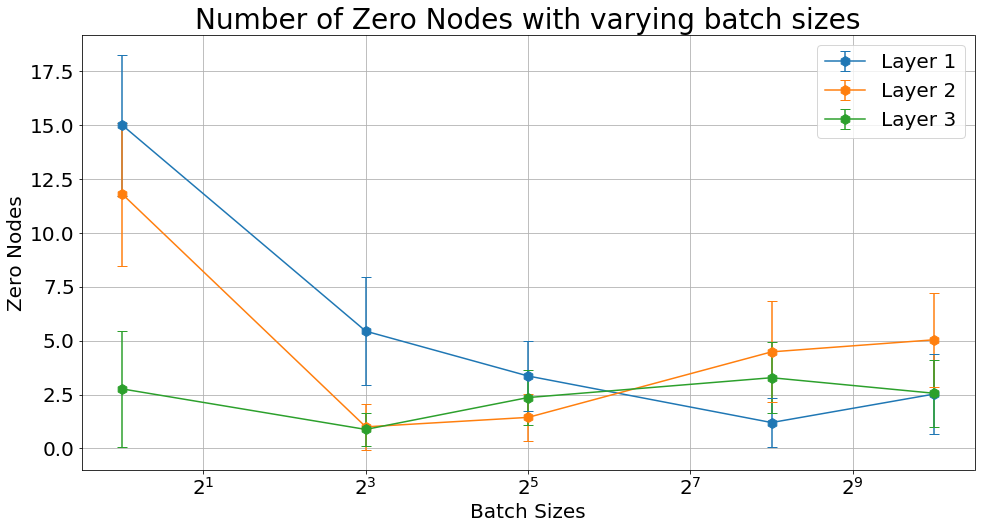

In [117]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Zero Nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Zero Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/zero_nodes_MLP_batch_mnist.png")

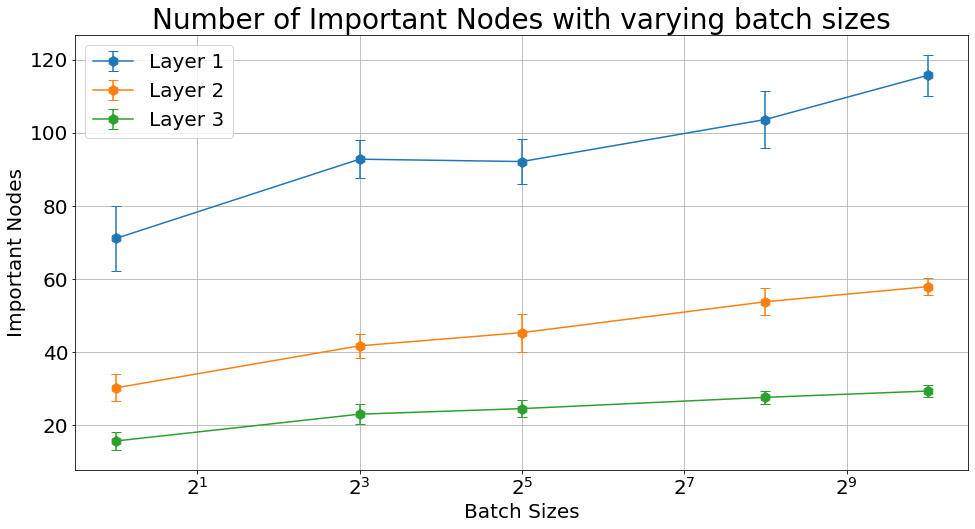

In [118]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Important Nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Important Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/imp_nodes_MLP_batch_mnist.png")

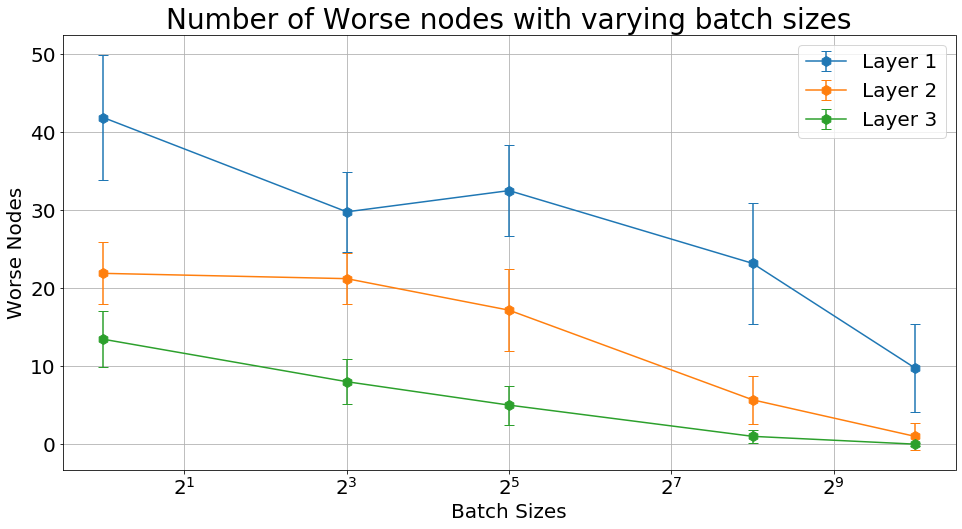

In [119]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Worse nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Worse Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/worse_nodes_MLP_batch_mnist.png")

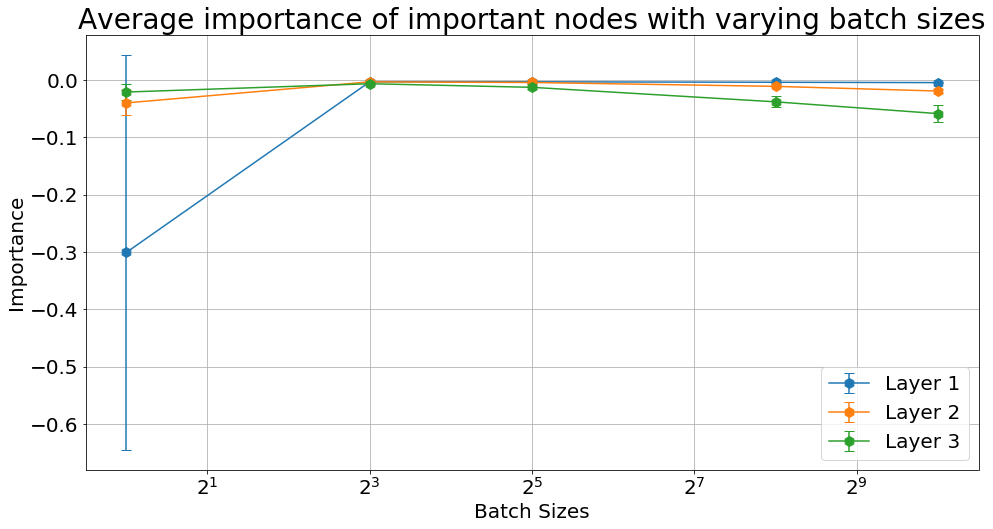

In [120]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Average importance of important nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/avg_imp_nodes_MLP_batch_mnist.png")

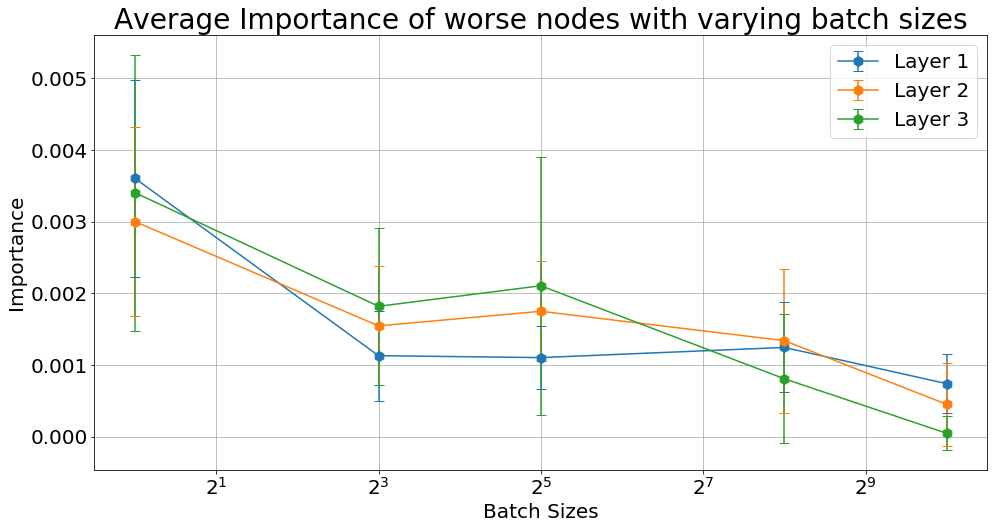

In [121]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Average Importance of worse nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/avg_worse_nodes_MLP_batch_mnist.png")

### Fashion MNIST

## Set seed

In [122]:
np.random.seed(2020)

In [123]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [124]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [125]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [126]:
trials = 25
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [32, 64, 128]
batch_sizes = [1, 8, 32, 256, 1024]
node_importance = np.zeros((trials, len(batch_sizes), len(layer_sizes), 3))
avg_node_imp = np.zeros((trials, len(batch_sizes), len(layer_sizes), 3))
accs = np.zeros((trials, len(batch_sizes)))
losses = np.zeros((trials, len(batch_sizes)))
for b, batch_size in enumerate(batch_sizes):
    for trial in tqdm.trange(trials):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(x_train, y_train, batch_size=batch_size, verbose=0, epochs=5)
        losses[trial, b], accs[trial, b] = model.evaluate(x_test, y_test, verbose=0)
        tmp_a, _, ai, az, aw = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
        for i, (nz, nw, ni) in enumerate(tmp_a):
            node_importance[trial, b, i, 0] = nz
            node_importance[trial, b, i, 1] = nw
            node_importance[trial, b, i, 2] = ni
            avg_node_imp[trial, b, i] = [az[i], aw[i], ai[i]]

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [07:00<00:00, 16.82s/it]


In [127]:
index = pd.MultiIndex.from_product([batch_sizes, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])

In [128]:
NI_1 = pd.DataFrame(node_importance[:, :, 2, :].reshape(trials, -1), columns=index)
NI_1.to_csv('../../../results/node_imp_MLP_l1_batch_fmnist.csv')
NI_1.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000   25.000000       25.000000  25.000000    25.00000   
mean   57.480000   29.680000       40.840000  33.160000    24.00000   
std     4.194441    7.081196        6.847627   4.374929     6.63325   
min    47.000000   20.000000       27.000000  22.000000    11.00000   
25%    54.000000   24.000000       37.000000  32.000000    20.00000   
50%    57.000000   27.000000       40.000000  33.000000    24.00000   
75%    61.000000   37.000000       46.000000  35.000000    29.00000   
max    64.000000   43.000000       54.000000  40.000000    37.00000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000   25.00000   25.000000       25.000000  25.000000   
mean        70.840000   17.84000   28.640000       81.520000  10.600000   
std          6.687551    3.63639    6.607319        7.567034   3.149074   
min         54.000000   12.00000   15.000000       64.000000   4.000000   
25%         68.000000   16.00000   24.000000       78.000000   9.000000   
50%         71.000000   18.00000   31.000000       80.000000  11.000000   
75%         76.000000   19.00000   34.000000       84.000000  13.000000   
max         81.000000   26.00000   38.000000      100.000000  16.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count    25.00000       25.000000  25.000000   25.000000       25.000000  
mean     27.60000       89.800000  10.680000   18.160000       99.160000  
std       6.56379        6.442049   3.262412    8.735369       10.048549  
min      17.00000       79.000000   6.000000    3.000000       73.000000  
25%      23.00000       86.000000   8.000000   13.000000       94.000000  
50%      29.00000       89.000000  11.000000   17.000000      100.000000  
75%      31.00000       96.000000  12.000000   24.000000      106.000000  
max      44.00000      102.000000  19.000000   36.000000      116.000000

In [129]:
AvgNI_1 = pd.DataFrame(avg_node_imp[:, :, 2, :].reshape(trials, -1), columns=index)
AvgNI_1.to_csv('../../../results/avg_node_imp_MLP_l1_batch_fmnist.csv')
AvgNI_1.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean   6.682770e-09    0.003877       -0.410604 -1.108350e-07    0.001526   
std    1.263603e-07    0.001902        0.405585  3.365475e-07    0.001129   
min   -2.606349e-07    0.001314       -1.485644 -7.269960e-07    0.000450   
25%   -4.518417e-08    0.002575       -0.604981 -3.068834e-07    0.000776   
50%    0.000000e+00    0.003590       -0.274520 -1.239149e-07    0.001175   
75%    7.163014e-08    0.004941       -0.124832  6.482005e-08    0.001619   
max    2.462356e-07    0.008388       -0.070251  6.299127e-07    0.005298   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.005480 -1.891962e-07    0.001651       -0.003526 -7.542446e-08   
std          0.001558  5.162635e-07    0.000863        0.000732  4.127224e-07   
min         -0.010280 -1.037493e-06    0.000329       -0.005741 -9.304947e-07   
25%         -0.005729 -5.861123e-07    0.000967       -0.003897 -3.036112e-07   
50%         -0.005460 -1.970265e-07    0.001371       -0.003455 -1.277242e-08   
75%         -0.003986  1.398417e-07    0.002355       -0.003017  1.064369e-08   
max         -0.003646  9.437402e-07    0.003405       -0.002237  7.450581e-07   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.002840       -0.006486 -2.815965e-07    0.002762       -0.012953  
std      0.001475        0.001212  5.512730e-07    0.002171        0.003446  
min      0.000779       -0.009876 -1.213380e-06    0.000235       -0.027191  
25%      0.001538       -0.007064 -6.109476e-07    0.001509       -0.013446  
50%      0.002902       -0.006143 -3.601114e-07    0.002040       -0.012276  
75%      0.003581       -0.005779  1.053015e-07    0.003533       -0.011343  
max      0.006898       -0.004834  1.045374e-06    0.010972       -0.009707

In [130]:
NI_2 = pd.DataFrame(node_importance[:, :, 1, :].reshape(trials, -1), columns=index)
NI_2.to_csv('../../../results/node_imp_MLP_l2_batch_fmnist.csv')
NI_2.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000   25.000000        25.00000  25.000000    25.00000   
mean   24.120000   20.640000        19.24000   3.000000    20.84000   
std     5.150405    4.768648         3.86523   1.802776     4.88774   
min    15.000000   12.000000        14.00000   0.000000    12.00000   
25%    20.000000   17.000000        17.00000   2.000000    18.00000   
50%    24.000000   20.000000        19.00000   3.000000    19.00000   
75%    28.000000   24.000000        21.00000   4.000000    25.00000   
max    33.000000   29.000000        28.00000   6.000000    32.00000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000   25.000000       25.000000  25.000000   
mean        40.160000   4.400000   16.880000       42.720000   6.640000   
std          5.112729   2.677063    5.109795        5.160103   2.360791   
min         30.000000   0.000000    6.000000       37.000000   2.000000   
25%         36.000000   3.000000   15.000000       38.000000   5.000000   
50%         41.000000   4.000000   17.000000       42.000000   7.000000   
75%         43.000000   6.000000   21.000000       45.000000   7.000000   
max         50.000000  10.000000   25.000000       53.000000  12.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  25.000000   25.000000       25.000000  
mean     8.560000       48.800000   9.000000    3.840000       51.160000  
std      4.164133        4.163332   2.915476    2.560599        3.681938  
min      3.000000       39.000000   5.000000    0.000000       44.000000  
25%      6.000000       47.000000   7.000000    2.000000       49.000000  
50%      8.000000       49.000000   8.000000    4.000000       52.000000  
75%     10.000000       52.000000  11.000000    5.000000       54.000000  
max     21.000000       57.000000  16.000000   12.000000       56.000000

In [131]:
AvgNI_2 = pd.DataFrame(avg_node_imp[:, :, 1, :].reshape(trials, -1), columns=index)
AvgNI_2.to_csv('../../../results/avg_node_imp_MLP_l2_batch_fmnist.csv')
AvgNI_2.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -5.681502e-08    0.002839       -0.333630  2.240539e-07    0.001700   
std    2.660100e-07    0.001603        0.240223  3.683241e-06    0.001057   
min   -7.403524e-07    0.000616       -1.168975 -9.447336e-06    0.000413   
25%   -1.163710e-07    0.001450       -0.374485 -2.980232e-07    0.000994   
50%   -2.636359e-08    0.002612       -0.274081  0.000000e+00    0.001407   
75%   -2.128737e-09    0.003084       -0.188914  8.692344e-07    0.002104   
max    5.424023e-07    0.006732       -0.060350  9.417534e-06    0.004853   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.005092  6.275707e-08    0.001964       -0.005160 -2.712096e-07   
std          0.001368  1.292734e-06    0.000980        0.000997  5.969939e-07   
min         -0.009622 -2.274911e-06    0.000306       -0.007389 -1.375164e-06   
25%         -0.005844 -4.097819e-07    0.001281       -0.005649 -7.003546e-07   
50%         -0.004907  0.000000e+00    0.001892       -0.005294 -2.026558e-07   
75%         -0.004071  1.102686e-06    0.002369       -0.004325  1.192093e-07   
max         -0.003320  2.135833e-06    0.004453       -0.003030  8.727823e-07   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.002991       -0.022081 -1.738589e-07    0.001795       -0.053596  
std      0.002272        0.005240  4.923028e-07    0.002070        0.009858  
min      0.000248       -0.036651 -1.614292e-06    0.000000       -0.074286  
25%      0.001498       -0.025983 -5.364418e-08    0.000402       -0.058869  
50%      0.003052       -0.020084 -3.725290e-09    0.001144       -0.051418  
75%      0.003739       -0.018875  4.967054e-09    0.002132       -0.047118  
max      0.010801       -0.013989  2.563000e-07    0.009237       -0.037656

In [132]:
NI_3 = pd.DataFrame(node_importance[:, :, 0, :].reshape(trials, -1), columns=index)
NI_3.to_csv('../../../results/node_imp_MLP_l3_batch_fmnist.csv')
NI_3.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000   25.000000       25.000000  25.000000   25.000000   
mean    5.520000   12.520000       13.960000   1.680000    8.760000   
std     3.163858    3.595367        2.791057   1.215182    2.961981   
min     1.000000    5.000000       11.000000   0.000000    3.000000   
25%     4.000000    9.000000       12.000000   1.000000    7.000000   
50%     4.000000   13.000000       14.000000   1.000000    9.000000   
75%     6.000000   14.000000       14.000000   2.000000   11.000000   
max    13.000000   19.000000       21.000000   4.000000   15.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000   25.000000        25.00000  25.000000   
mean        21.560000   3.480000    5.000000        23.52000   3.400000   
std          3.136877   1.939072    1.979057         2.45153   1.755942   
min         14.000000   1.000000    1.000000        20.00000   1.000000   
25%         20.000000   2.000000    4.000000        22.00000   2.000000   
50%         22.000000   3.000000    5.000000        23.00000   3.000000   
75%         24.000000   5.000000    6.000000        25.00000   5.000000   
max         27.000000   7.000000    9.000000        29.00000   7.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  25.000000   25.000000       25.000000  
mean     1.880000       26.720000   5.400000    0.560000       26.040000  
std      1.129897        1.989975   2.254625    0.650641        2.524546  
min      0.000000       22.000000   1.000000    0.000000       21.000000  
25%      1.000000       25.000000   4.000000    0.000000       24.000000  
50%      2.000000       27.000000   5.000000    0.000000       26.000000  
75%      2.000000       28.000000   7.000000    1.000000       28.000000  
max      5.000000       30.000000  11.000000    2.000000       31.000000

In [133]:
AvgNI_3 = pd.DataFrame(avg_node_imp[:, :, 0, :].reshape(trials, -1), columns=index)
AvgNI_3.to_csv('../../../results/avg_node_imp_MLP_l3_batch_fmnist.csv')
AvgNI_3.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -3.444634e-07    0.002819       -0.093291 -3.229578e-07    0.001991   
std    6.208512e-07    0.001573        0.057021  1.904263e-06    0.001320   
min   -2.063811e-06    0.000971       -0.304506 -3.948808e-06    0.000211   
25%   -6.281413e-07    0.001629       -0.108449 -1.460314e-06    0.000974   
50%   -1.896511e-08    0.002689       -0.070962  0.000000e+00    0.001639   
75%    0.000000e+00    0.003599       -0.059669  0.000000e+00    0.002896   
max    7.674098e-07    0.007959       -0.023059  4.798174e-06    0.004918   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.013309 -9.652830e-08    0.002905       -0.023051 -3.441459e-08   
std          0.004705  1.078845e-06    0.002648        0.008227  1.052945e-06   
min         -0.027763 -2.676249e-06    0.000186       -0.044289 -3.039837e-06   
25%         -0.015594 -1.986821e-07    0.001184       -0.026312  0.000000e+00   
50%         -0.012482  0.000000e+00    0.002451       -0.021356  0.000000e+00   
75%         -0.010310  1.117587e-07    0.004084       -0.018136  0.000000e+00   
max         -0.007358  1.966953e-06    0.010275       -0.010947  2.518296e-06   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.001715       -0.073321 -7.968535e-08    0.001224       -0.159276  
std      0.002027        0.016465  9.502379e-07    0.003326        0.037343  
min      0.000000       -0.106589 -3.119310e-06    0.000000       -0.258354  
25%      0.000270       -0.085549 -1.277242e-07    0.000000       -0.177801  
50%      0.001021       -0.068733  0.000000e+00    0.000000       -0.156640  
75%      0.002477       -0.063127  8.568168e-08    0.000286       -0.130018  
max      0.008144       -0.042868  2.662341e-06    0.014098       -0.089441

In [134]:
A = pd.DataFrame(accs, columns=batch_sizes)
A.to_csv('../../../results/acc_MLP_batch_fmnist.csv')
A.describe()

,1,8,32,256,1024
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.844756,0.868124,0.869064,0.861972,0.849424
std,0.008459,0.006117,0.005829,0.004834,0.005130
min,0.825800,0.854300,0.857000,0.851000,0.835100
25%,0.839700,0.865100,0.864400,0.859600,0.846700
50%,0.847400,0.868100,0.870000,0.862100,0.850800
75%,0.850400,0.871500,0.873500,0.865900,0.852900
max,0.857200,0.877300,0.877800,0.868900,0.856800


In [135]:
L = pd.DataFrame(losses, columns=batch_sizes)
L.to_csv('../../../results/loss_MLP_batch_fmnist.csv')
L.describe()

,1,8,32,256,1024
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.508051,0.373585,0.366228,0.382077,0.426556
std,0.049309,0.018635,0.014655,0.011928,0.011208
min,0.436655,0.348269,0.344653,0.365048,0.408423
25%,0.475298,0.357916,0.356220,0.372182,0.418965
50%,0.503495,0.370803,0.362452,0.381768,0.425415
75%,0.528889,0.380894,0.373965,0.391108,0.437312
max,0.630362,0.417417,0.398165,0.407371,0.454106


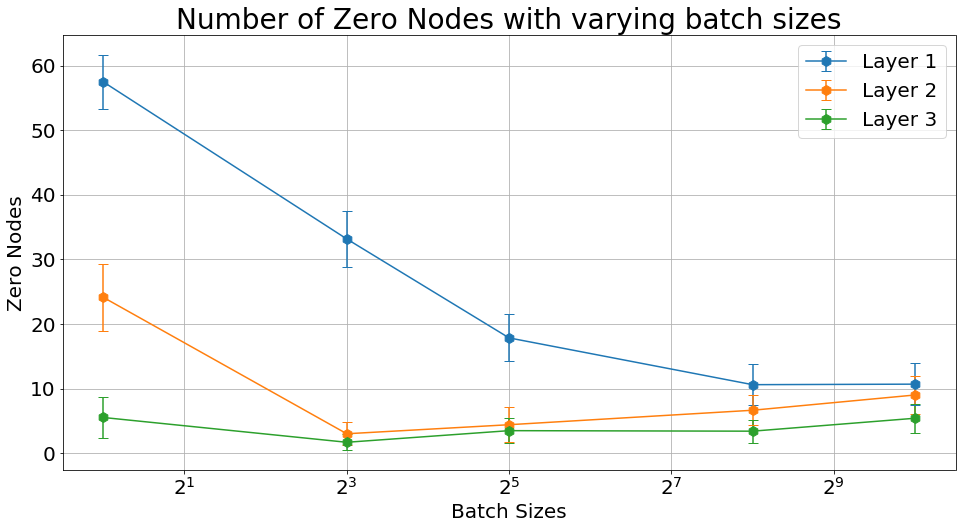

In [136]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Zero Nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Zero Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/zero_nodes_MLP_batch_fmnist.png")

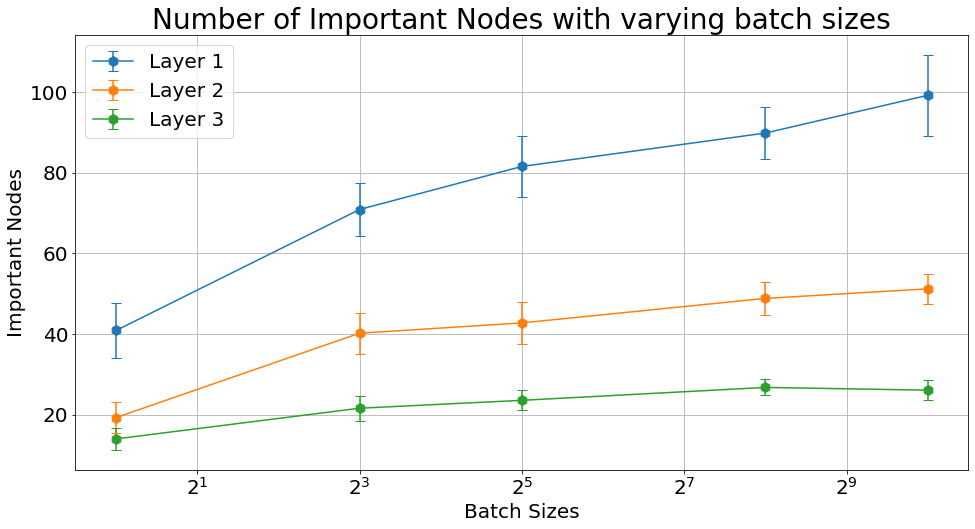

In [137]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Important Nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Important Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/imp_nodes_MLP_batch_fmnist.png")

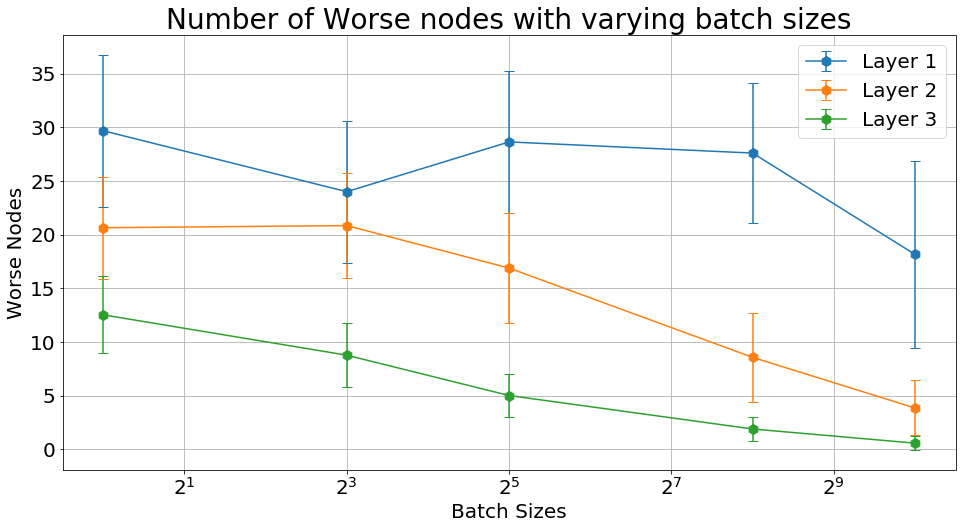

In [138]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Worse nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Worse Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/worse_nodes_MLP_batch_fmnist.png")

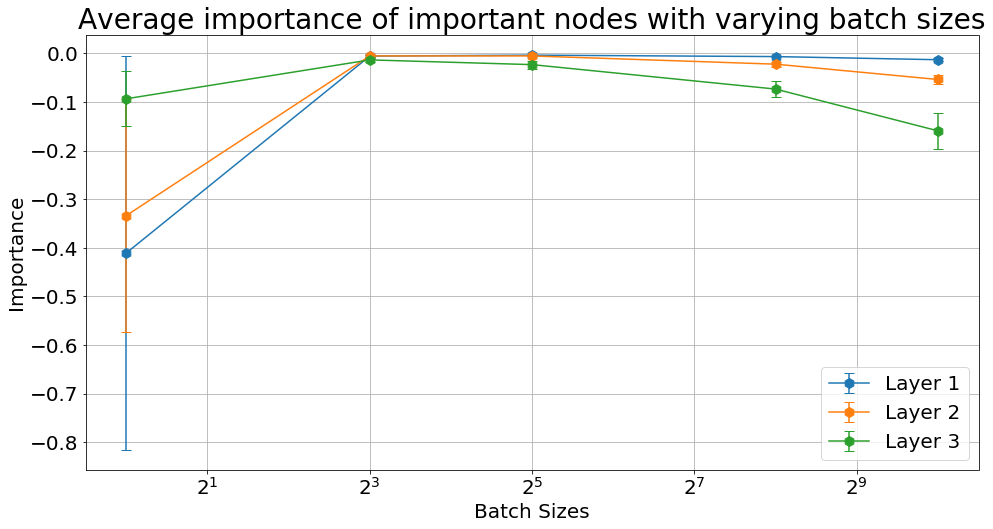

In [139]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Average importance of important nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/avg_imp_nodes_MLP_batch_fmnist.png")

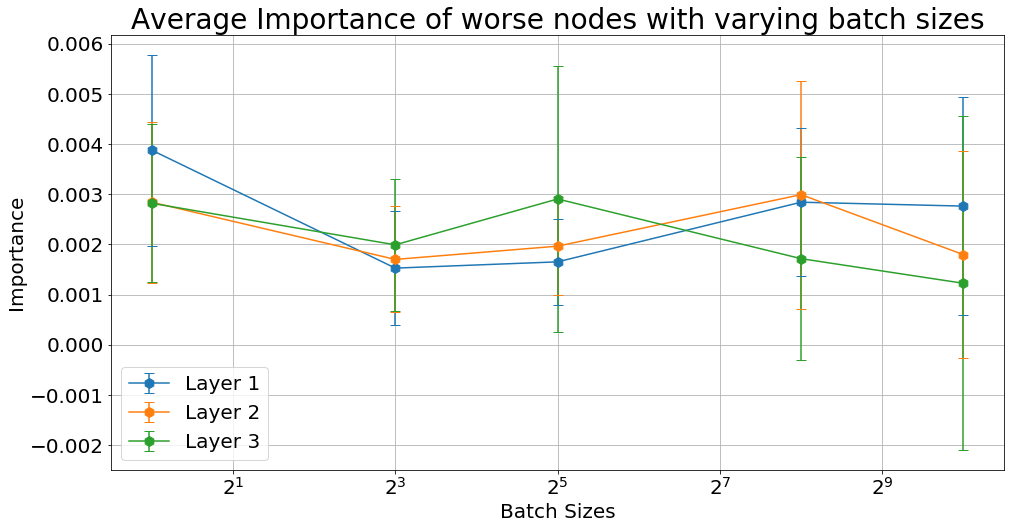

In [140]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Average Importance of worse nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/avg_worse_nodes_MLP_batch_fmnist.png")

## Convolutional Neural Network

### MNIST

#### Set seed

In [12]:
np.random.seed(2020)

In [13]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [15]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
trials = 15
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [64, 256, 128, 64, 32]
batch_sizes = [1, 8, 32, 256, 1024]
node_importance = np.zeros((trials, len(batch_sizes), len(layer_sizes), 3))
avg_node_imp = np.zeros((trials, len(batch_sizes), len(layer_sizes), 3))
accs = np.zeros((trials, len(batch_sizes)))
losses = np.zeros((trials, len(batch_sizes)))
for b, batch_size in enumerate(batch_sizes):
    reset_keras()
    for trial in tqdm.trange(trials):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
            ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(x_train, y_train, batch_size=batch_size, verbose=0, epochs=5)
        losses[trial, b], accs[trial, b] = model.evaluate(x_test, y_test, verbose=0)
        tmp_a, _, ai, az, aw = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
        for i, (nz, nw, ni) in enumerate(tmp_a):
            node_importance[trial, b, i, 0] = nz
            node_importance[trial, b, i, 1] = nw
            node_importance[trial, b, i, 2] = ni
            avg_node_imp[trial, b, i] = [az[i], aw[i], ai[i]]

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

4370
0


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

31964
0


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

27705
0


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

27705
0


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

19897
0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [17:39<00:00, 70.63s/it]


In [17]:
index = pd.MultiIndex.from_product([batch_sizes, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])

In [18]:
NI_1 = pd.DataFrame(node_importance[:, :, 4, :].reshape(trials, -1), columns=index)
NI_1.to_csv('../../../results/node_imp_CNN_l1_batch_mnist.csv')
NI_1.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  15.000000   15.000000       15.000000  15.000000   15.000000   
mean   25.333333    0.933333        5.733333  13.533333    6.866667   
std     1.112697    0.883715        1.222799   1.726543    2.875181   
min    23.000000    0.000000        4.000000  10.000000    3.000000   
25%    25.000000    0.000000        5.000000  13.000000    5.000000   
50%    25.000000    1.000000        6.000000  14.000000    6.000000   
75%    26.000000    1.000000        7.000000  15.000000    8.500000   
max    27.000000    3.000000        7.000000  16.000000   14.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       15.000000  15.000000   15.000000       15.000000  15.000000   
mean        11.600000   2.866667   15.133333       14.000000   0.266667   
std          3.333809   1.552264    3.622680        2.618615   0.593617   
min          7.000000   0.000000   10.000000       10.000000   0.000000   
25%          9.000000   2.000000   12.000000       12.000000   0.000000   
50%         11.000000   3.000000   16.000000       13.000000   0.000000   
75%         13.500000   3.500000   18.000000       16.000000   0.000000   
max         18.000000   6.000000   20.000000       19.000000   2.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  15.000000   15.000000        15.00000  
mean    12.066667       19.666667   0.200000    9.000000        22.80000  
std      4.131182        3.829708   0.560612    5.567764         5.80886  
min      5.000000       11.000000   0.000000    0.000000        14.00000  
25%      9.500000       18.000000   0.000000    4.500000        18.50000  
50%     12.000000       20.000000   0.000000    9.000000        23.00000  
75%     14.000000       22.500000   0.000000   13.500000        27.50000  
max     21.000000       25.000000   2.000000   18.000000        32.00000

In [19]:
AvgNI_1 = pd.DataFrame(avg_node_imp[:, :, 4, :].reshape(trials, -1), columns=index)
AvgNI_1.to_csv('../../../results/avg_node_imp_CNN_l1_batch_mnist.csv')
AvgNI_1.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  1.500000e+01   15.000000       15.000000  1.500000e+01   15.000000   
mean  -1.366780e-08    0.002805       -0.112717  1.681433e-07    0.001429   
std    8.795015e-08    0.005502        0.080099  5.205821e-07    0.000992   
min   -3.109808e-07    0.000000       -0.335650 -9.957169e-07    0.000346   
25%    0.000000e+00    0.000000       -0.149005 -1.924733e-08    0.000829   
50%    0.000000e+00    0.000184       -0.091470  0.000000e+00    0.001063   
75%    0.000000e+00    0.003155       -0.059916  5.368299e-07    0.001536   
max    1.192093e-07    0.021192       -0.025112  9.556611e-07    0.004045   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       15.000000  1.500000e+01   15.000000       15.000000  1.500000e+01   
mean        -0.005679  8.830180e-08    0.001316       -0.002568  5.637606e-08   
std          0.002577  1.356445e-06    0.000982        0.001495  3.583059e-07   
min         -0.011259 -2.709528e-06    0.000399       -0.006313 -4.395843e-07   
25%         -0.007573 -3.352761e-07    0.000547       -0.003255  0.000000e+00   
50%         -0.004783  0.000000e+00    0.000923       -0.002013  0.000000e+00   
75%         -0.003756  6.292636e-07    0.001730       -0.001653  0.000000e+00   
max         -0.002688  2.869715e-06    0.003301       -0.000708  1.285225e-06   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  1.500000e+01   15.000000       15.000000  
mean     0.001209       -0.002442 -1.231829e-07    0.001034       -0.003891  
std      0.000879        0.001228  4.770854e-07    0.001069        0.001983  
min      0.000278       -0.004999 -1.847744e-06    0.000000       -0.008735  
25%      0.000382       -0.003356  0.000000e+00    0.000368       -0.005095  
50%      0.001023       -0.001972  0.000000e+00    0.000482       -0.002625  
75%      0.001952       -0.001567  0.000000e+00    0.001301       -0.002381  
max      0.002978       -0.000869  0.000000e+00    0.003849       -0.001987

In [20]:
NI_2 = pd.DataFrame(node_importance[:, :, 3, :].reshape(trials, -1), columns=index)
NI_2.to_csv('../../../results/node_imp_CNN_l2_batch_mnist.csv')
NI_2.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  15.000000   15.000000       15.000000  15.000000   15.000000   
mean   39.600000    5.466667       18.933333   9.200000   24.666667   
std     2.443651    5.396648        3.918211   3.468223    5.727960   
min    34.000000    0.000000        9.000000   4.000000   12.000000   
25%    39.000000    1.500000       17.000000   6.500000   21.000000   
50%    40.000000    5.000000       19.000000   8.000000   26.000000   
75%    41.000000    7.500000       22.000000  12.000000   28.500000   
max    43.000000   21.000000       24.000000  15.000000   32.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       15.000000  15.000000   15.000000       15.000000  15.000000   
mean        30.133333   2.266667   30.133333       31.600000   0.600000   
std          5.841559   1.279881    4.838339        4.762952   0.736788   
min         20.000000   0.000000   22.000000       25.000000   0.000000   
25%         27.000000   1.000000   26.500000       27.000000   0.000000   
50%         29.000000   2.000000   30.000000       31.000000   0.000000   
75%         32.500000   3.000000   35.000000       36.000000   1.000000   
max         45.000000   4.000000   37.000000       39.000000   2.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  15.000000   15.000000       15.000000  
mean    27.733333       35.666667   0.400000   18.800000       44.800000  
std      4.651677        4.730851   0.632456    7.032577        6.836875  
min     18.000000       29.000000   0.000000    4.000000       37.000000  
25%     26.000000       33.500000   0.000000   14.000000       39.000000  
50%     27.000000       36.000000   0.000000   21.000000       43.000000  
75%     30.500000       37.500000   1.000000   25.000000       48.500000  
max     35.000000       46.000000   2.000000   26.000000       60.000000

In [21]:
AvgNI_2 = pd.DataFrame(avg_node_imp[:, :, 3, :].reshape(trials, -1), columns=index)
AvgNI_2.to_csv('../../../results/avg_node_imp_CNN_l2_batch_mnist.csv')
AvgNI_2.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  1.500000e+01   15.000000       15.000000  1.500000e+01   15.000000   
mean  -1.839811e-08    0.003517       -0.014990 -3.116811e-07    0.001058   
std    1.703906e-07    0.005703        0.005777  5.467611e-07    0.000828   
min   -4.108995e-07    0.000000       -0.029881 -1.489495e-06    0.000331   
25%   -9.058928e-08    0.000637       -0.017671 -6.264697e-07    0.000680   
50%    0.000000e+00    0.001846       -0.012619 -1.920594e-07    0.000814   
75%    1.054701e-07    0.003968       -0.011218  1.019488e-07    0.001219   
max    2.313601e-07    0.022713       -0.007901  2.905726e-07    0.003721   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       15.000000  1.500000e+01   15.000000       15.000000  1.500000e+01   
mean        -0.001371 -8.655815e-07    0.000928       -0.001006  5.325923e-07   
std          0.000732  2.789904e-06    0.000533        0.000492  3.349011e-06   
min         -0.003589 -8.787960e-06    0.000304       -0.002059 -8.005649e-06   
25%         -0.001581 -9.127737e-07    0.000520       -0.001197  0.000000e+00   
50%         -0.001230  0.000000e+00    0.000670       -0.000836  0.000000e+00   
75%         -0.000932  6.606181e-07    0.001313       -0.000669  1.708046e-06   
max         -0.000632  1.788139e-06    0.001996       -0.000467  6.368384e-06   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  1.500000e+01   15.000000       15.000000  
mean     0.000834       -0.001400 -5.948047e-07    0.001131       -0.002715  
std      0.000497        0.000559  2.042470e-06    0.001077        0.001015  
min      0.000212       -0.002261 -7.573515e-06    0.000169       -0.005355  
25%      0.000438       -0.001804  0.000000e+00    0.000425       -0.003366  
50%      0.000735       -0.001477  0.000000e+00    0.000862       -0.002285  
75%      0.001034       -0.000860  0.000000e+00    0.001523       -0.002105  
max      0.001770       -0.000645  1.434237e-06    0.004396       -0.001404

In [22]:
NI_3 = pd.DataFrame(node_importance[:, :, 2, :].reshape(trials, -1), columns=index)
NI_3.to_csv('../../../results/node_imp_CNN_l3_batch_mnist.csv')
NI_3.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  15.000000   15.000000       15.000000  15.000000   15.000000   
mean   84.800000   13.133333       30.066667  29.933333   44.800000   
std     3.609511    6.685450        7.304271   6.123336    7.163399   
min    79.000000    4.000000       14.000000  21.000000   31.000000   
25%    82.500000    7.500000       28.000000  24.500000   39.500000   
50%    85.000000   13.000000       31.000000  31.000000   43.000000   
75%    87.000000   17.000000       36.000000  34.500000   52.000000   
max    91.000000   26.000000       39.000000  40.000000   55.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       15.000000  15.000000   15.000000       15.000000  15.000000   
mean        53.266667  10.133333   53.266667       64.600000   3.200000   
std          6.192930   3.292126    8.370583        8.740709   1.780851   
min         42.000000   4.000000   37.000000       50.000000   1.000000   
25%         50.000000   8.000000   47.000000       60.000000   2.000000   
50%         53.000000  11.000000   55.000000       64.000000   3.000000   
75%         57.000000  12.000000   59.500000       67.000000   4.500000   
max         62.000000  16.000000   67.000000       87.000000   7.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  15.000000   15.000000       15.000000  
mean    50.933333       73.866667   1.533333   43.333333       83.133333  
std      5.993647        5.705469   1.641718    9.663382        9.500877  
min     42.000000       66.000000   0.000000   23.000000       65.000000  
25%     45.500000       69.500000   0.000000   37.000000       79.000000  
50%     53.000000       73.000000   1.000000   44.000000       83.000000  
75%     55.500000       78.500000   2.500000   47.500000       87.000000  
max     60.000000       85.000000   5.000000   61.000000      105.000000

In [23]:
AvgNI_3 = pd.DataFrame(avg_node_imp[:, :, 2, :].reshape(trials, -1), columns=index)
AvgNI_3.to_csv('../../../results/avg_node_imp_CNN_l3_batch_mnist.csv')
AvgNI_3.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  1.500000e+01   15.000000       15.000000  1.500000e+01   15.000000   
mean  -7.668489e-08    0.001911       -0.057117 -2.616529e-08    0.000712   
std    1.037161e-07    0.001673        0.056523  3.219655e-07    0.000506   
min   -2.102128e-07    0.000119       -0.165907 -5.601905e-07    0.000365   
25%   -1.452820e-07    0.000658       -0.094746 -2.254745e-07    0.000473   
50%   -1.092167e-07    0.001760       -0.024521 -2.048910e-08    0.000540   
75%   -2.006470e-08    0.002609       -0.011740  1.858341e-07    0.000711   
max    1.817942e-07    0.006064       -0.006115  4.961409e-07    0.002427   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       15.000000  1.500000e+01   15.000000       15.000000  1.500000e+01   
mean        -0.000936 -4.943801e-07    0.000635       -0.000577 -2.743635e-07   
std          0.000494  1.115638e-06    0.000356        0.000201  3.463747e-06   
min         -0.002358 -2.837740e-06    0.000252       -0.001032 -8.791685e-06   
25%         -0.001026 -8.989207e-07    0.000392       -0.000673 -2.196338e-06   
50%         -0.000803 -3.860755e-07    0.000536       -0.000600  0.000000e+00   
75%         -0.000618 -6.715871e-08    0.000763       -0.000437  1.791399e-06   
max         -0.000490  1.965091e-06    0.001581       -0.000259  4.348656e-06   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  1.500000e+01   15.000000       15.000000  
mean     0.000543       -0.000627 -4.183501e-08    0.000674       -0.001185  
std      0.000213        0.000200  2.522743e-06    0.000384        0.000483  
min      0.000246       -0.001001 -5.776063e-06    0.000203       -0.002446  
25%      0.000376       -0.000769  0.000000e+00    0.000426       -0.001269  
50%      0.000568       -0.000637  0.000000e+00    0.000562       -0.001015  
75%      0.000654       -0.000491  4.475005e-07    0.000746       -0.000883  
max      0.000979       -0.000305  4.568448e-06    0.001620       -0.000629

In [24]:
NI_4 = pd.DataFrame(node_importance[:, :, 1, :].reshape(trials, -1), columns=index)
NI_4.to_csv('../../../results/node_imp_CNN_l4_batch_mnist.csv')
NI_4.describe()

1                                      8                 \
       Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count   15.000000   15.000000        15.00000  15.000000   15.000000   
mean   186.866667   26.933333        42.20000  78.666667   94.800000   
std      8.749422   11.677002        10.65833   9.044862   16.967195   
min    163.000000    9.000000        26.00000  65.000000   62.000000   
25%    184.500000   18.500000        38.50000  73.000000   84.500000   
50%    189.000000   25.000000        40.00000  77.000000   99.000000   
75%    190.500000   32.500000        49.50000  83.000000  107.000000   
max    199.000000   51.000000        58.00000  98.000000  120.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       15.000000  15.000000   15.000000       15.000000  15.000000   
mean        82.533333  57.000000  119.600000       79.400000  27.933333   
std         15.869408   8.409179    9.811072       12.932793   3.712271   
min         61.000000  49.000000  106.000000       44.000000  23.000000   
25%         72.500000  51.000000  112.000000       74.000000  25.000000   
50%         76.000000  53.000000  118.000000       80.000000  27.000000   
75%         93.000000  60.500000  128.000000       86.000000  31.000000   
max        117.000000  80.000000  133.000000       99.000000  33.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  15.000000   15.000000        15.00000  
mean   113.266667      114.800000  22.266667   95.133333       138.60000  
std      7.235495        7.301663   5.496319   13.367694        12.81071  
min     98.000000      105.000000  15.000000   74.000000       109.00000  
25%    109.500000      111.500000  18.500000   87.500000       131.50000  
50%    114.000000      115.000000  21.000000   94.000000       142.00000  
75%    117.000000      116.000000  26.500000   99.500000       146.50000  
max    126.000000      135.000000  34.000000  130.000000       154.00000

In [25]:
AvgNI_4 = pd.DataFrame(avg_node_imp[:, :, 1, :].reshape(trials, -1), columns=index)
AvgNI_4.to_csv('../../../results/avg_node_imp_CNN_l4_batch_mnist.csv')
AvgNI_4.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  1.500000e+01   15.000000       15.000000  1.500000e+01   15.000000   
mean  -7.538846e-08    0.001615       -0.005416 -9.004635e-08    0.000383   
std    7.059480e-08    0.000835        0.002240  4.500909e-07    0.000256   
min   -2.071990e-07    0.000584       -0.010133 -7.192294e-07    0.000201   
25%   -1.241302e-07    0.000974       -0.006988 -5.062192e-07    0.000266   
50%   -5.924986e-08    0.001381       -0.005398  5.174581e-08    0.000314   
75%   -2.398811e-08    0.002002       -0.003529  2.007891e-07    0.000381   
max    4.214111e-08    0.003228       -0.002669  8.076225e-07    0.001259   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       15.000000  1.500000e+01   15.000000       15.000000  1.500000e+01   
mean        -0.000227 -5.866441e-08    0.000268       -0.000171  3.171750e-08   
std          0.000098  4.647086e-07    0.000103        0.000101  6.761560e-07   
min         -0.000525 -9.021777e-07    0.000123       -0.000500 -1.012037e-06   
25%         -0.000250 -3.132303e-07    0.000182       -0.000189 -4.011942e-07   
50%         -0.000193 -1.897902e-07    0.000275       -0.000164  1.946765e-08   
75%         -0.000169  3.022066e-07    0.000339       -0.000109  5.397946e-07   
max         -0.000131  8.970347e-07    0.000495       -0.000079  1.091024e-06   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  1.500000e+01   15.000000       15.000000  
mean     0.000209       -0.000181  9.285213e-09    0.000335       -0.000423  
std      0.000069        0.000051  6.638231e-07    0.000143        0.000162  
min      0.000116       -0.000254 -1.239064e-06    0.000148       -0.000743  
25%      0.000164       -0.000219 -3.205515e-07    0.000267       -0.000430  
50%      0.000192       -0.000202  2.439085e-07    0.000315       -0.000394  
75%      0.000257       -0.000133  4.822464e-07    0.000375       -0.000322  
max      0.000327       -0.000091  1.092397e-06    0.000625       -0.000239

In [26]:
NI_5 = pd.DataFrame(node_importance[:, :, 0, :].reshape(trials, -1), columns=index)
NI_5.to_csv('../../../results/node_imp_CNN_l5_batch_mnist.csv')
NI_5.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  15.000000   15.000000       15.000000  15.000000   15.000000   
mean   38.933333    7.733333       17.333333  18.533333   21.466667   
std     5.483308    5.945787        3.598942   4.437932    4.926121   
min    28.000000    0.000000       11.000000  13.000000   12.000000   
25%    37.000000    4.500000       16.000000  15.000000   18.000000   
50%    40.000000    7.000000       17.000000  18.000000   22.000000   
75%    43.000000    8.000000       18.500000  20.500000   26.000000   
max    46.000000   22.000000       27.000000  29.000000   29.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count        15.00000  15.000000   15.000000       15.000000  15.000000   
mean         24.00000  25.533333   16.000000       22.466667  25.466667   
std           3.70328   5.986493    4.956958        3.181793   4.155318   
min          19.00000  16.000000    8.000000       18.000000  19.000000   
25%          21.00000  21.000000   12.500000       20.500000  22.500000   
50%          24.00000  25.000000   15.000000       22.000000  25.000000   
75%          27.50000  30.500000   19.000000       23.500000  28.000000   
max          31.00000  34.000000   26.000000       30.000000  33.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  15.000000   15.000000       15.000000  
mean     7.600000       30.933333  22.600000    3.866667       37.533333  
std      4.188419        3.769552   3.737837    2.924445        4.657815  
min      0.000000       23.000000  16.000000    0.000000       29.000000  
25%      5.000000       28.000000  20.500000    1.500000       34.500000  
50%      7.000000       31.000000  22.000000    4.000000       36.000000  
75%     11.000000       33.500000  25.500000    5.000000       41.500000  
max     14.000000       37.000000  28.000000    9.000000       44.000000

In [27]:
AvgNI_5 = pd.DataFrame(avg_node_imp[:, :, 0, :].reshape(trials, -1), columns=index)
AvgNI_5.to_csv('../../../results/avg_node_imp_CNN_l5_batch_mnist.csv')
AvgNI_5.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  1.500000e+01   15.000000       15.000000  1.500000e+01   15.000000   
mean  -6.336547e-08    0.001048       -0.034528 -3.741451e-07    0.001034   
std    2.062515e-07    0.000889        0.019035  9.584336e-07    0.001149   
min   -4.201166e-07    0.000000       -0.067471 -3.389154e-06    0.000259   
25%   -1.582882e-07    0.000376       -0.043172 -6.160281e-07    0.000470   
50%   -2.160668e-08    0.000726       -0.035574 -4.880130e-08    0.000660   
75%    0.000000e+00    0.001554       -0.021072  1.117232e-07    0.001127   
max    3.214393e-07    0.002720       -0.005154  6.825264e-07    0.004842   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       15.000000  1.500000e+01   15.000000       15.000000  1.500000e+01   
mean        -0.001746 -1.349857e-07    0.001441       -0.002488  2.291369e-08   
std          0.000684  2.628983e-07    0.000946        0.001334  7.133767e-08   
min         -0.003376 -5.607449e-07    0.000371       -0.005830 -3.601114e-08   
25%         -0.002066 -2.717466e-07    0.000827       -0.003164  0.000000e+00   
50%         -0.001582 -2.091243e-07    0.001202       -0.001987  0.000000e+00   
75%         -0.001147  2.420761e-08    0.001546       -0.001584  0.000000e+00   
max         -0.000985  3.945260e-07    0.003996       -0.001044  2.513138e-07   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  1.500000e+01   15.000000       15.000000  
mean     0.001557       -0.006069 -3.692768e-09    0.001128       -0.012888  
std      0.000994        0.002313  1.367696e-08    0.000809        0.004613  
min      0.000000       -0.010856 -5.308539e-08    0.000000       -0.025326  
25%      0.000678       -0.006564  0.000000e+00    0.000510       -0.013625  
50%      0.001631       -0.006011  0.000000e+00    0.001116       -0.012381  
75%      0.002289       -0.004388  0.000000e+00    0.001380       -0.010651  
max      0.003056       -0.003374  0.000000e+00    0.003052       -0.006792

In [28]:
A = pd.DataFrame(accs, columns=batch_sizes)
A.to_csv('../../../results/acc_CNN_batch_mnist.csv')
A.describe()

,1,8,32,256,1024
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.975467,0.988300,0.989240,0.989680,0.988213
std,0.005914,0.002283,0.002152,0.001642,0.001190
min,0.966400,0.983900,0.984600,0.986900,0.986100
25%,0.970300,0.987250,0.988300,0.988450,0.987500
50%,0.975500,0.989000,0.989300,0.990200,0.988100
75%,0.980250,0.989950,0.990400,0.991200,0.989000
max,0.984400,0.990900,0.993200,0.991500,0.990900


In [29]:
L = pd.DataFrame(losses, columns=batch_sizes)
L.to_csv('../../../results/loss_CNN_batch_mnist.csv')
L.describe()

,1,8,32,256,1024
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.101382,0.046612,0.038591,0.031418,0.035997
std,0.028533,0.012734,0.008822,0.005351,0.003108
min,0.058630,0.032839,0.024723,0.024632,0.030204
25%,0.084041,0.036774,0.032366,0.027095,0.033928
50%,0.097875,0.043259,0.037414,0.031002,0.036751
75%,0.108817,0.052585,0.042853,0.033723,0.037423
max,0.174389,0.076049,0.054729,0.041622,0.042142


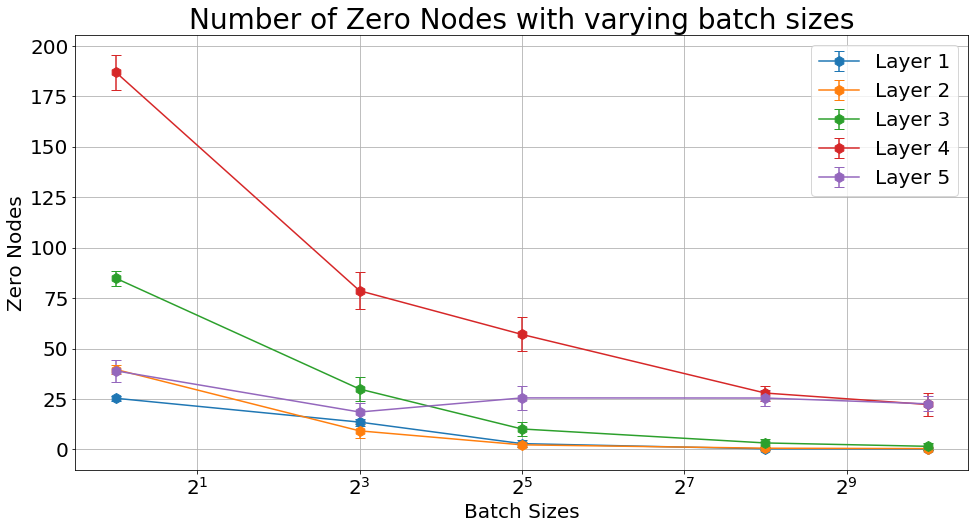

In [41]:
plt.rcParams["figure.figsize"] = (16,8)
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_4 = NI_4.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_4 = NI_4.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_5 = NI_5.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_5 = NI_5.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.errorbar(x=batch_sizes, y=m_4, yerr=std_4, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 4')
plt.errorbar(x=batch_sizes, y=m_5, yerr=std_5, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 5')
plt.legend(fontsize=20)
plt.title("Number of Zero Nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Zero Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/zero_nodes_CNN_batch_mnist.png")

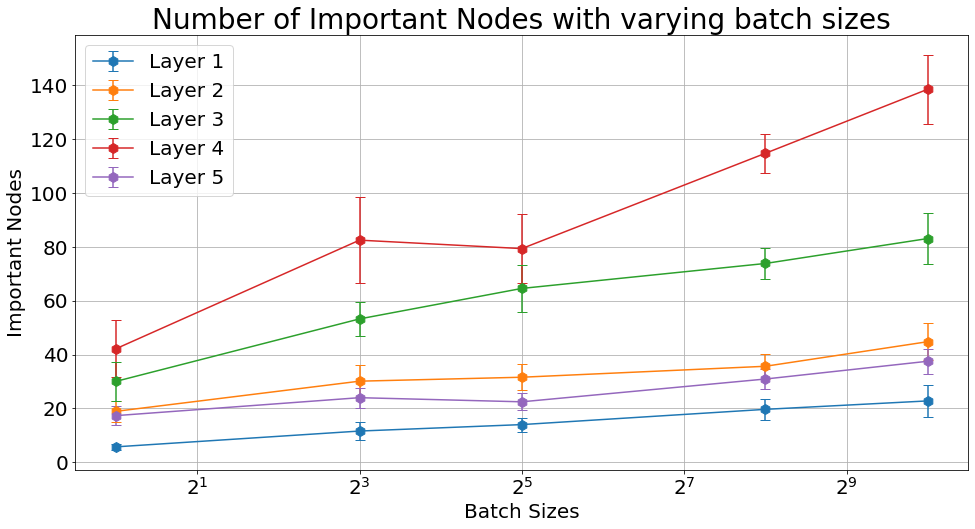

In [42]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_4 = NI_4.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_4 = NI_4.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_5 = NI_5.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_5 = NI_5.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.errorbar(x=batch_sizes, y=m_4, yerr=std_4, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 4')
plt.errorbar(x=batch_sizes, y=m_5, yerr=std_5, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 5')
plt.legend(fontsize=20)
plt.title("Number of Important Nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Important Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/imp_nodes_CNN_batch_mnist.png")

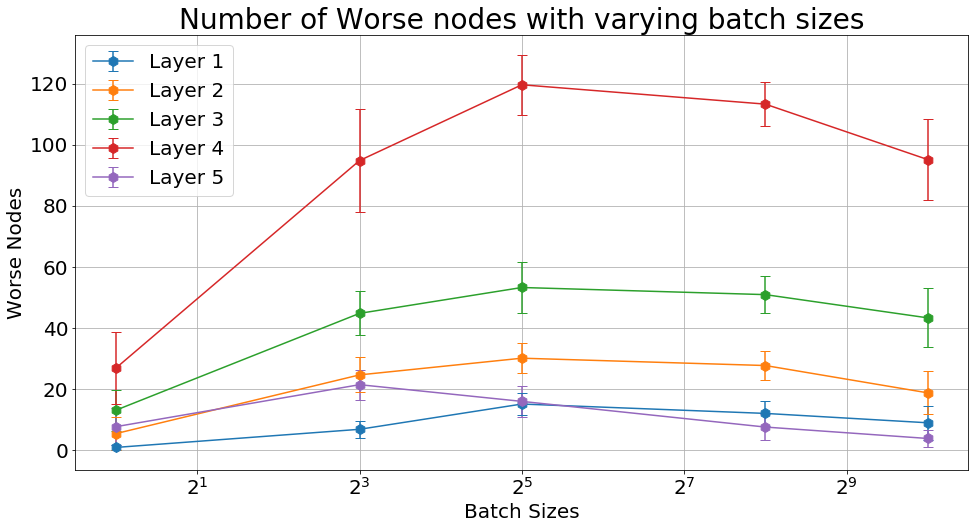

In [43]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_4 = NI_4.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_4 = NI_4.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_5 = NI_5.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_5 = NI_5.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.errorbar(x=batch_sizes, y=m_4, yerr=std_4, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 4')
plt.errorbar(x=batch_sizes, y=m_5, yerr=std_5, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 5')
plt.legend(fontsize=20)
plt.title("Number of Worse nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Worse Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/worse_nodes_CNN_batch_mnist.png")

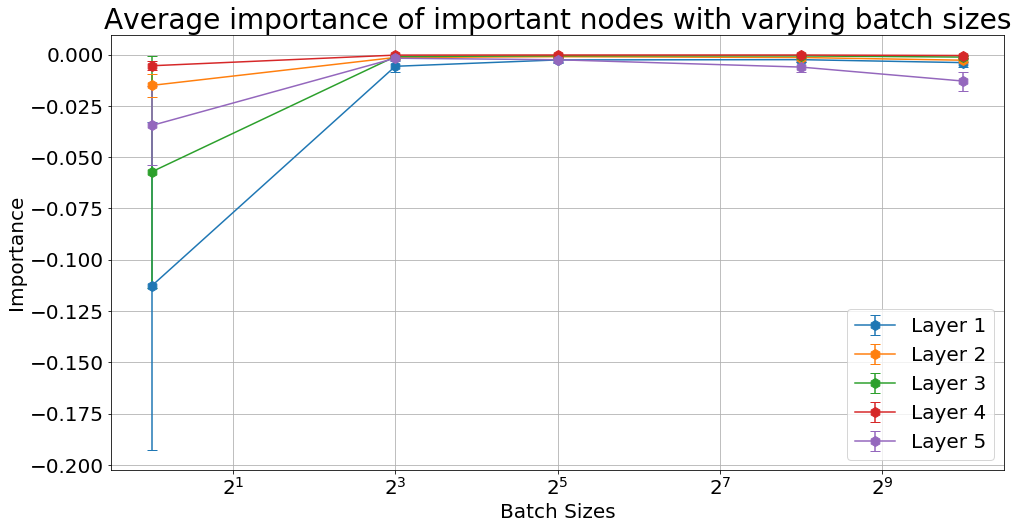

In [44]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_4 = AvgNI_4.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_4 = AvgNI_4.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_5 = AvgNI_5.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_5 = AvgNI_5.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.errorbar(x=batch_sizes, y=m_4, yerr=std_4, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 4')
plt.errorbar(x=batch_sizes, y=m_5, yerr=std_5, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 5')
plt.legend(fontsize=20)
plt.title("Average importance of important nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/avg_imp_nodes_CNN_batch_mnist.png")

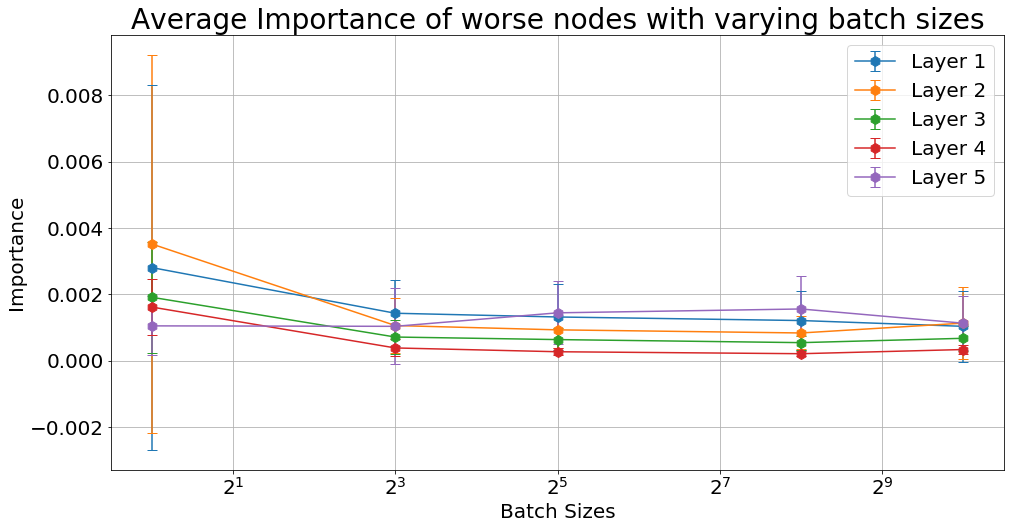

In [45]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_4 = AvgNI_4.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_4 = AvgNI_4.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_5 = AvgNI_5.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_5 = AvgNI_5.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.errorbar(x=batch_sizes, y=m_4, yerr=std_4, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 4')
plt.errorbar(x=batch_sizes, y=m_5, yerr=std_5, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 5')
plt.legend(fontsize=20)
plt.title("Average Importance of worse nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/avg_worse_nodes_CNN_batch_mnist.png")

### Fashion MNIST

## Set seed

In [46]:
np.random.seed(2020)

In [47]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [48]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [49]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [51]:
trials = 15
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [64, 256, 128, 64, 32]
batch_sizes = [1, 8, 32, 256, 1024]
node_importance = np.zeros((trials, len(batch_sizes), len(layer_sizes), 3))
avg_node_imp = np.zeros((trials, len(batch_sizes), len(layer_sizes), 3))
accs = np.zeros((trials, len(batch_sizes)))
losses = np.zeros((trials, len(batch_sizes)))
for b, batch_size in enumerate(batch_sizes):
    reset_keras()
    for trial in tqdm.trange(trials):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
            ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(x_train, y_train, batch_size=batch_size, verbose=0, epochs=5)
        losses[trial, b], accs[trial, b] = model.evaluate(x_test, y_test, verbose=0)
        tmp_a, _, ai, az, aw = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
        for i, (nz, nw, ni) in enumerate(tmp_a):
            node_importance[trial, b, i, 0] = nz
            node_importance[trial, b, i, 1] = nw
            node_importance[trial, b, i, 2] = ni
            avg_node_imp[trial, b, i] = [az[i], aw[i], ai[i]]

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

1662
0


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

9264
0


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

34094
0


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

34094
0


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

40505
0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [17:36<00:00, 70.40s/it]


In [52]:
index = pd.MultiIndex.from_product([batch_sizes, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])

In [53]:
NI_1 = pd.DataFrame(node_importance[:, :, 4, :].reshape(trials, -1), columns=index)
NI_1.to_csv('../../../results/node_imp_CNN_l1_batch_fmnist.csv')
NI_1.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  15.000000   15.000000       15.000000  15.000000   15.000000   
mean   22.000000    1.400000        8.600000   5.266667    9.333333   
std     1.690309    1.404076        1.723783   1.533747    4.775932   
min    19.000000    0.000000        5.000000   3.000000    2.000000   
25%    21.000000    0.000000        8.000000   4.000000    7.000000   
50%    22.000000    2.000000        8.000000   5.000000    9.000000   
75%    23.000000    2.000000        9.500000   6.000000   11.000000   
max    25.000000    4.000000       12.000000   8.000000   18.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       15.000000  15.000000   15.000000       15.000000  15.000000   
mean        17.400000   0.600000   12.133333       19.266667   0.266667   
std          4.136942   0.736788    4.533473        4.495500   0.457738   
min         10.000000   0.000000    4.000000       12.000000   0.000000   
25%         15.000000   0.000000   10.000000       16.000000   0.000000   
50%         17.000000   0.000000   12.000000       19.000000   0.000000   
75%         21.000000   1.000000   15.500000       21.000000   0.500000   
max         24.000000   2.000000   20.000000       28.000000   1.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  15.000000   15.000000       15.000000  
mean    10.333333       21.400000   0.400000    8.533333       23.066667  
std      3.958114        3.960519   0.507093    3.739111        3.844600  
min      4.000000       14.000000   0.000000    2.000000       16.000000  
25%      7.500000       20.000000   0.000000    6.000000       20.500000  
50%     11.000000       21.000000   0.000000    7.000000       25.000000  
75%     12.000000       24.000000   1.000000   11.500000       25.500000  
max     18.000000       28.000000   1.000000   15.000000       30.000000

In [54]:
AvgNI_1 = pd.DataFrame(avg_node_imp[:, :, 4, :].reshape(trials, -1), columns=index)
AvgNI_1.to_csv('../../../results/avg_node_imp_CNN_l1_batch_fmnist.csv')
AvgNI_1.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  1.500000e+01   15.000000       15.000000  1.500000e+01   15.000000   
mean  -1.851055e-09    0.012608       -0.061309 -1.453029e-07    0.001824   
std    6.330650e-08    0.026955        0.052719  8.930393e-07    0.001012   
min   -1.803041e-07    0.000000       -0.189461 -1.698732e-06    0.000621   
25%    0.000000e+00    0.000000       -0.073650 -5.374352e-07    0.001127   
50%    0.000000e+00    0.002745       -0.032562 -1.986821e-08    0.001662   
75%    0.000000e+00    0.005497       -0.029638  0.000000e+00    0.002121   
max    1.537800e-07    0.081746       -0.019074  1.877546e-06    0.004239   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       15.000000  1.500000e+01   15.000000       15.000000  1.500000e+01   
mean        -0.006690  4.981955e-07    0.001345       -0.003850 -3.993511e-07   
std          0.002685  1.475067e-06    0.000670        0.001081  1.231865e-06   
min         -0.013173 -9.164214e-07    0.000103       -0.005604 -4.738569e-06   
25%         -0.007694 -2.235174e-08    0.000822       -0.004845  0.000000e+00   
50%         -0.006058  0.000000e+00    0.001473       -0.003636  0.000000e+00   
75%         -0.004570  0.000000e+00    0.001760       -0.002922  0.000000e+00   
max         -0.003675  4.932284e-06    0.002650       -0.002562  0.000000e+00   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  1.500000e+01   15.000000       15.000000  
mean     0.001873       -0.006153  8.026759e-07    0.002287       -0.008197  
std      0.000980        0.002060  2.163330e-06    0.002005        0.002726  
min      0.000520       -0.012113  0.000000e+00    0.000215       -0.014209  
25%      0.001066       -0.006761  0.000000e+00    0.000910       -0.009614  
50%      0.001675       -0.006200  0.000000e+00    0.001991       -0.007335  
75%      0.002606       -0.004957  0.000000e+00    0.003072       -0.006411  
max      0.003514       -0.003460  7.182360e-06    0.008095       -0.004805

In [55]:
NI_2 = pd.DataFrame(node_importance[:, :, 3, :].reshape(trials, -1), columns=index)
NI_2.to_csv('../../../results/node_imp_CNN_l2_batch_fmnist.csv')
NI_2.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  15.000000   15.000000       15.000000  15.000000   15.000000   
mean   36.400000    8.600000       19.000000   4.466667   26.466667   
std     3.333809    5.207138        3.817254   1.641718    7.199868   
min    30.000000    1.000000       13.000000   2.000000   12.000000   
25%    35.500000    5.500000       16.500000   3.500000   23.000000   
50%    37.000000    8.000000       20.000000   5.000000   27.000000   
75%    38.500000   12.000000       21.000000   6.000000   29.000000   
max    40.000000   19.000000       26.000000   7.000000   40.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       15.000000  15.000000   15.000000        15.00000  15.000000   
mean        33.066667   0.933333   27.866667        35.20000   0.200000   
std          6.776711   0.961150    7.558029         7.62702   0.414039   
min         20.000000   0.000000   14.000000        23.00000   0.000000   
25%         30.000000   0.000000   25.000000        30.50000   0.000000   
50%         33.000000   1.000000   28.000000        33.00000   0.000000   
75%         37.500000   1.500000   32.500000        38.00000   0.000000   
max         46.000000   3.000000   41.000000        50.00000   1.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  15.000000    15.00000       15.000000  
mean    22.866667       40.933333   0.266667    21.60000       42.133333  
std      6.128000        6.088240   0.457738     5.79162        5.804760  
min     10.000000       32.000000   0.000000     9.00000       33.000000  
25%     19.000000       37.500000   0.000000    19.00000       37.500000  
50%     24.000000       40.000000   0.000000    20.00000       43.000000  
75%     26.500000       44.500000   0.500000    26.50000       45.000000  
max     32.000000       54.000000   1.000000    31.00000       55.000000

In [56]:
AvgNI_2 = pd.DataFrame(avg_node_imp[:, :, 3, :].reshape(trials, -1), columns=index)
AvgNI_2.to_csv('../../../results/avg_node_imp_CNN_l2_batch_fmnist.csv')
AvgNI_2.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  1.500000e+01   15.000000       15.000000  1.500000e+01   15.000000   
mean  -6.274898e-08    0.006318       -0.030139 -1.363196e-07    0.001688   
std    1.474525e-07    0.009430        0.043718  9.669564e-07    0.000743   
min   -4.480282e-07    0.000048       -0.183760 -2.791484e-06    0.000630   
25%   -8.287844e-08    0.001211       -0.025152 -3.218651e-07    0.001228   
50%   -5.119886e-08    0.003206       -0.017545  0.000000e+00    0.001535   
75%    0.000000e+00    0.005756       -0.012009  3.909781e-07    0.001894   
max    2.460820e-07    0.035950       -0.008106  1.375874e-06    0.003246   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       15.000000  1.500000e+01   15.000000       15.000000  1.500000e+01   
mean        -0.002076  8.228752e-07    0.001105       -0.001616  1.509984e-07   
std          0.000494  2.185507e-06    0.000336        0.000404  5.848144e-07   
min         -0.003547 -2.413988e-06    0.000531       -0.002450  0.000000e+00   
25%         -0.002230  0.000000e+00    0.000863       -0.001819  0.000000e+00   
50%         -0.001996  0.000000e+00    0.001146       -0.001624  0.000000e+00   
75%         -0.001817  1.639128e-07    0.001246       -0.001305  0.000000e+00   
max         -0.001349  5.781651e-06    0.001801       -0.001085  2.264977e-06   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  1.500000e+01   15.000000       15.000000  
mean     0.001570       -0.002722  3.715356e-07    0.002278       -0.004485  
std      0.000794        0.000787  1.438951e-06    0.001274        0.001358  
min      0.000528       -0.004356  0.000000e+00    0.000941       -0.007696  
25%      0.000946       -0.003173  0.000000e+00    0.001420       -0.005137  
50%      0.001525       -0.002627  0.000000e+00    0.001785       -0.004366  
75%      0.002162       -0.002115  0.000000e+00    0.003317       -0.003224  
max      0.003289       -0.001668  5.573034e-06    0.004709       -0.002851

In [57]:
NI_3 = pd.DataFrame(node_importance[:, :, 2, :].reshape(trials, -1), columns=index)
NI_3.to_csv('../../../results/node_imp_CNN_l3_batch_fmnist.csv')
NI_3.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  15.000000   15.000000       15.000000  15.000000   15.000000   
mean   89.666667   13.066667       25.266667  29.666667   43.866667   
std     5.037951    6.227435        6.984336   5.924123    8.331238   
min    78.000000    1.000000       15.000000  22.000000   29.000000   
25%    86.500000    9.000000       18.500000  25.500000   38.000000   
50%    89.000000   13.000000       25.000000  29.000000   45.000000   
75%    93.500000   18.000000       30.500000  34.000000   49.000000   
max    96.000000   25.000000       37.000000  42.000000   59.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       15.000000  15.000000   15.000000       15.000000  15.000000   
mean        54.466667   9.666667   49.466667       68.866667   3.066667   
std          7.079817   3.677473    8.131655        6.186006   1.387015   
min         41.000000   4.000000   31.000000       58.000000   1.000000   
25%         51.000000   7.500000   46.500000       65.000000   2.000000   
50%         53.000000   9.000000   51.000000       68.000000   3.000000   
75%         57.500000  10.500000   54.000000       72.500000   4.000000   
max         69.000000  17.000000   63.000000       83.000000   5.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  15.000000   15.000000       15.000000  
mean    47.666667       77.266667   2.333333   45.266667       80.400000  
std      9.633770        9.035380   1.799471    8.030893        8.201045  
min     23.000000       66.000000   0.000000   31.000000       68.000000  
25%     43.500000       70.500000   1.000000   38.500000       74.500000  
50%     47.000000       76.000000   2.000000   44.000000       83.000000  
75%     56.000000       82.000000   3.000000   51.500000       85.500000  
max     59.000000      100.000000   6.000000   57.000000       96.000000

In [58]:
AvgNI_3 = pd.DataFrame(avg_node_imp[:, :, 2, :].reshape(trials, -1), columns=index)
AvgNI_3.to_csv('../../../results/avg_node_imp_CNN_l3_batch_fmnist.csv')
AvgNI_3.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  1.500000e+01   15.000000       15.000000  1.500000e+01   15.000000   
mean  -4.148578e-08    0.004123       -0.802389  3.802136e-08    0.001157   
std    9.223401e-08    0.005918        1.372420  2.877204e-07    0.000468   
min   -1.893324e-07    0.000037       -5.264318 -3.942422e-07    0.000458   
25%   -1.137907e-07    0.001239       -0.810974 -1.806943e-07    0.000872   
50%   -2.235174e-08    0.001797       -0.201614 -3.681463e-08    0.001127   
75%    9.986948e-09    0.004084       -0.100764  2.005009e-07    0.001302   
max    1.195197e-07    0.022242       -0.049810  6.212638e-07    0.002194   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       15.000000  1.500000e+01   15.000000       15.000000  1.500000e+01   
mean        -0.001960  8.190205e-08    0.000740       -0.000945  7.316470e-07   
std          0.000490  1.083166e-06    0.000222        0.000191  3.096786e-06   
min         -0.002966 -2.060831e-06    0.000425       -0.001382 -4.068017e-06   
25%         -0.002191 -4.253217e-07    0.000587       -0.001005  0.000000e+00   
50%         -0.001861  8.727823e-08    0.000670       -0.000904  3.337860e-07   
75%         -0.001602  8.940697e-07    0.000868       -0.000810  1.195818e-06   
max         -0.001285  1.464039e-06    0.001271       -0.000729  9.447336e-06   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  1.500000e+01   15.000000       15.000000  
mean     0.001004       -0.001378  5.086263e-08    0.001610       -0.002488  
std      0.000455        0.000383  8.303063e-07    0.000696        0.000701  
min      0.000409       -0.002151 -1.668930e-06    0.000684       -0.003897  
25%      0.000684       -0.001610  0.000000e+00    0.001109       -0.002890  
50%      0.000847       -0.001455  0.000000e+00    0.001530       -0.002394  
75%      0.001233       -0.001099  1.937151e-07    0.001915       -0.001891  
max      0.001793       -0.000765  1.400709e-06    0.003403       -0.001506

In [59]:
NI_4 = pd.DataFrame(node_importance[:, :, 1, :].reshape(trials, -1), columns=index)
NI_4.to_csv('../../../results/node_imp_CNN_l4_batch_fmnist.csv')
NI_4.describe()

1                                      8                 \
       Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count   15.000000   15.000000       15.000000  15.000000   15.000000   
mean   206.200000   18.466667       31.333333  64.666667  114.866667   
std     24.208027   15.546551       10.526610   7.393691   17.095808   
min    123.000000    5.000000       21.000000  41.000000   78.000000   
25%    208.000000    8.500000       26.500000  64.000000  111.000000   
50%    211.000000   14.000000       28.000000  67.000000  117.000000   
75%    217.000000   22.500000       33.500000  68.000000  123.000000   
max    227.000000   67.000000       66.000000  73.000000  149.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       15.000000  15.000000   15.000000       15.000000  15.000000   
mean        76.466667  44.266667  132.333333       79.400000  28.000000   
std         14.121244   6.702523   21.708019       22.395153   5.988083   
min         59.000000  35.000000   82.000000       41.000000  20.000000   
25%         66.500000  39.000000  123.500000       66.500000  22.500000   
50%         74.000000  43.000000  134.000000       78.000000  29.000000   
75%         80.000000  49.500000  141.000000       92.000000  32.500000   
max        111.000000  56.000000  172.000000      129.000000  38.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  15.000000   15.000000       15.000000  
mean   108.733333      119.266667  21.866667   96.066667      138.066667  
std     15.549307       14.429467   3.681356    8.171961        9.137573  
min     73.000000      102.000000  16.000000   84.000000      120.000000  
25%    104.000000      109.500000  19.500000   89.000000      133.000000  
50%    112.000000      115.000000  22.000000   97.000000      138.000000  
75%    119.500000      126.500000  24.500000  100.000000      144.000000  
max    128.000000      150.000000  28.000000  110.000000      154.000000

In [60]:
AvgNI_4 = pd.DataFrame(avg_node_imp[:, :, 1, :].reshape(trials, -1), columns=index)
AvgNI_4.to_csv('../../../results/avg_node_imp_CNN_l4_batch_fmnist.csv')
AvgNI_4.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  1.500000e+01   15.000000       15.000000  1.500000e+01   15.000000   
mean  -3.301316e-08    0.002777       -0.027815  1.282045e-07    0.000645   
std    4.119163e-08    0.002180        0.013590  3.987109e-07    0.000234   
min   -1.030609e-07    0.000519       -0.052686 -7.995404e-07    0.000321   
25%   -5.481583e-08    0.000904       -0.041164 -3.441159e-08    0.000523   
50%   -2.142929e-08    0.002056       -0.025164  1.359476e-07    0.000561   
75%    2.580676e-09    0.004314       -0.016128  4.102729e-07    0.000691   
max    1.270759e-08    0.007208       -0.008458  7.910764e-07    0.001178   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       15.000000  1.500000e+01   15.000000       15.000000  1.500000e+01   
mean        -0.000474 -3.923611e-08    0.000384       -0.000243  1.463592e-07   
std          0.000142  3.955499e-07    0.000113        0.000054  4.812830e-07   
min         -0.000796 -7.319450e-07    0.000240       -0.000353 -4.569689e-07   
25%         -0.000501 -3.794537e-07    0.000298       -0.000278 -2.227090e-07   
50%         -0.000436  2.554485e-09    0.000360       -0.000235  2.709302e-08   
75%         -0.000364  1.797453e-07    0.000446       -0.000200  3.946080e-07   
max         -0.000330  8.062824e-07    0.000624       -0.000175  1.432567e-06   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  1.500000e+01   15.000000       15.000000  
mean     0.000494       -0.000454 -2.933947e-08    0.001164       -0.001354  
std      0.000175        0.000135  3.366475e-07    0.000436        0.000364  
min      0.000267       -0.000747 -7.535730e-07    0.000601       -0.002035  
25%      0.000348       -0.000509 -1.462443e-07    0.000819       -0.001543  
50%      0.000436       -0.000471  0.000000e+00    0.001066       -0.001382  
75%      0.000636       -0.000350  5.874496e-08    0.001344       -0.001021  
max      0.000799       -0.000228  6.542964e-07    0.002063       -0.000887

In [61]:
NI_5 = pd.DataFrame(node_importance[:, :, 0, :].reshape(trials, -1), columns=index)
NI_5.to_csv('../../../results/node_imp_CNN_l5_batch_fmnist.csv')
NI_5.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  15.000000   15.000000       15.000000  15.000000   15.000000   
mean   36.800000    8.600000       18.600000  18.333333   23.600000   
std     7.523297    4.579457        4.626013   3.309438    5.729622   
min    20.000000    3.000000       11.000000  12.000000   12.000000   
25%    36.000000    6.000000       16.500000  16.000000   20.000000   
50%    38.000000    8.000000       18.000000  18.000000   24.000000   
75%    39.000000    9.500000       20.000000  21.500000   28.000000   
max    47.000000   20.000000       31.000000  23.000000   32.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       15.000000  15.000000   15.000000        15.00000  15.000000   
mean        22.066667  26.333333   13.066667        24.60000  24.800000   
std          4.682287   3.921856    5.522249         3.81351   4.394802   
min         17.000000  20.000000    5.000000        18.00000  16.000000   
25%         19.000000  25.000000   10.000000        22.00000  21.500000   
50%         21.000000  26.000000   11.000000        25.00000  26.000000   
75%         24.000000  28.000000   14.500000        27.50000  28.000000   
max         36.000000  37.000000   25.000000        30.00000  31.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  15.000000   15.000000       15.000000  
mean     7.133333       32.066667  23.800000    5.466667       34.733333  
std      5.139020        3.058166   4.678217    3.204164        4.495500  
min      0.000000       26.000000  14.000000    0.000000       27.000000  
25%      3.500000       31.500000  21.000000    3.000000       32.000000  
50%      6.000000       32.000000  24.000000    6.000000       34.000000  
75%     10.500000       34.000000  25.500000    7.500000       37.000000  
max     16.000000       37.000000  33.000000   11.000000       44.000000

In [62]:
AvgNI_5 = pd.DataFrame(avg_node_imp[:, :, 0, :].reshape(trials, -1), columns=index)
AvgNI_5.to_csv('../../../results/avg_node_imp_CNN_l5_batch_fmnist.csv')
AvgNI_5.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  1.500000e+01   15.000000       15.000000  1.500000e+01   15.000000   
mean  -6.635444e-08    0.004994       -0.047250 -7.928322e-08    0.001388   
std    1.243317e-07    0.009010        0.034733  3.564867e-07    0.000636   
min   -3.007325e-07    0.000193       -0.122453 -9.453959e-07    0.000735   
25%   -1.306717e-07    0.000557       -0.056387 -2.677129e-07    0.001010   
50%   -5.799371e-08    0.001026       -0.033211  0.000000e+00    0.001165   
75%    0.000000e+00    0.003268       -0.023429  1.320377e-07    0.001516   
max    1.254835e-07    0.029784       -0.015385  5.091230e-07    0.002820   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       15.000000  1.500000e+01   15.000000       15.000000  1.500000e+01   
mean        -0.006034 -7.348413e-08    0.001469       -0.005699  2.824650e-08   
std          0.002700  2.057212e-07    0.000681        0.001753  2.257640e-07   
min         -0.013461 -4.178286e-07    0.000288       -0.008772 -3.541891e-07   
25%         -0.006884 -2.569291e-07    0.000945       -0.007288  0.000000e+00   
50%         -0.005659 -9.169945e-09    0.001526       -0.005674  0.000000e+00   
75%         -0.004284  4.557700e-08    0.001736       -0.004016  0.000000e+00   
max         -0.002879  2.079067e-07    0.002878       -0.003751  5.919825e-07   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  1.500000e+01   15.000000       15.000000  
mean     0.003426       -0.016777 -5.732765e-09    0.004029       -0.044960  
std      0.002310        0.004754  5.844720e-08    0.003176        0.018222  
min      0.000000       -0.028265 -1.913117e-07    0.000000       -0.083357  
25%      0.001808       -0.018900  0.000000e+00    0.001114       -0.050147  
50%      0.002783       -0.014902  0.000000e+00    0.003808       -0.041048  
75%      0.005616       -0.013386  0.000000e+00    0.005474       -0.031733  
max      0.007411       -0.011765  1.082295e-07    0.009879       -0.024109

In [63]:
A = pd.DataFrame(accs, columns=batch_sizes)
A.to_csv('../../../results/acc_CNN_batch_fmnist.csv')
A.describe()

,1,8,32,256,1024
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.867367,0.906513,0.911353,0.897607,0.871513
std,0.007199,0.004395,0.003745,0.004866,0.004890
min,0.850200,0.897500,0.903400,0.888800,0.863100
25%,0.862750,0.904150,0.909150,0.894600,0.868550
50%,0.869200,0.907900,0.912100,0.897000,0.870900
75%,0.871350,0.908950,0.913200,0.900750,0.874150
max,0.879600,0.913600,0.917200,0.906800,0.882100


In [64]:
L = pd.DataFrame(losses, columns=batch_sizes)
L.to_csv('../../../results/loss_CNN_batch_fmnist.csv')
L.describe()

,1,8,32,256,1024
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.401914,0.280719,0.252580,0.281630,0.354028
std,0.035670,0.015250,0.008808,0.012001,0.012726
min,0.363536,0.256543,0.239586,0.265235,0.327924
25%,0.376095,0.271252,0.245922,0.269724,0.344585
50%,0.388935,0.278844,0.249011,0.282295,0.355734
75%,0.419191,0.285497,0.259287,0.290893,0.361448
max,0.487800,0.319584,0.270835,0.300914,0.372761


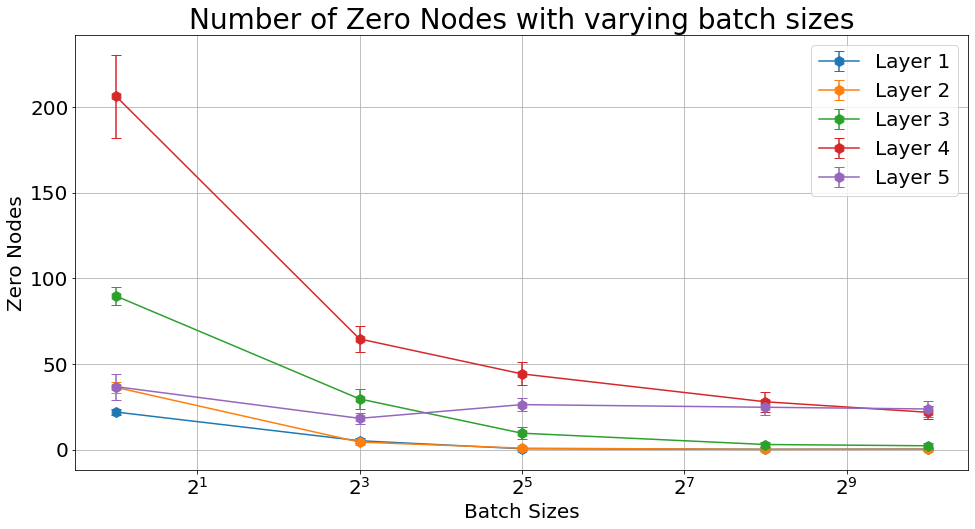

In [65]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_4 = NI_4.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_4 = NI_4.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_5 = NI_5.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_5 = NI_5.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.errorbar(x=batch_sizes, y=m_4, yerr=std_4, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 4')
plt.errorbar(x=batch_sizes, y=m_5, yerr=std_5, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 5')
plt.legend(fontsize=20)
plt.title("Number of Zero Nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Zero Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/zero_nodes_CNN_batch_fmnist.png")

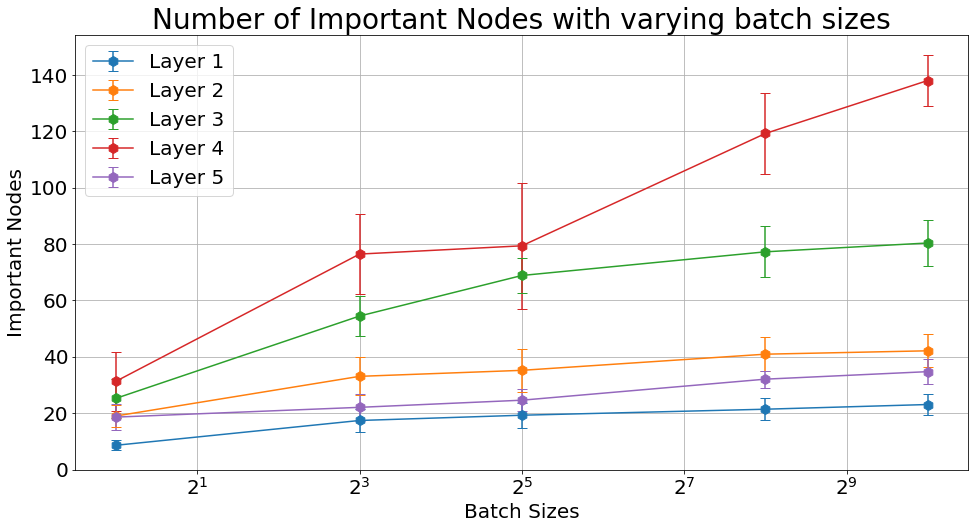

In [66]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_4 = NI_4.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_4 = NI_4.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_5 = NI_5.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_5 = NI_5.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.errorbar(x=batch_sizes, y=m_4, yerr=std_4, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 4')
plt.errorbar(x=batch_sizes, y=m_5, yerr=std_5, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 5')
plt.legend(fontsize=20)
plt.title("Number of Important Nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Important Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/imp_nodes_CNN_batch_fmnist.png")

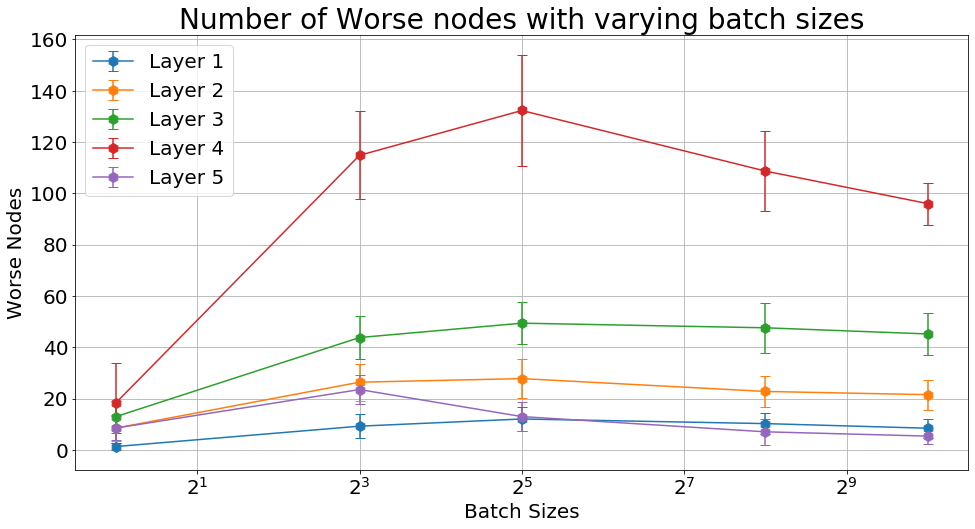

In [67]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_4 = NI_4.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_4 = NI_4.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_5 = NI_5.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_5 = NI_5.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.errorbar(x=batch_sizes, y=m_4, yerr=std_4, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 4')
plt.errorbar(x=batch_sizes, y=m_5, yerr=std_5, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 5')
plt.legend(fontsize=20)
plt.title("Number of Worse nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Worse Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/worse_nodes_CNN_batch_fmnist.png")

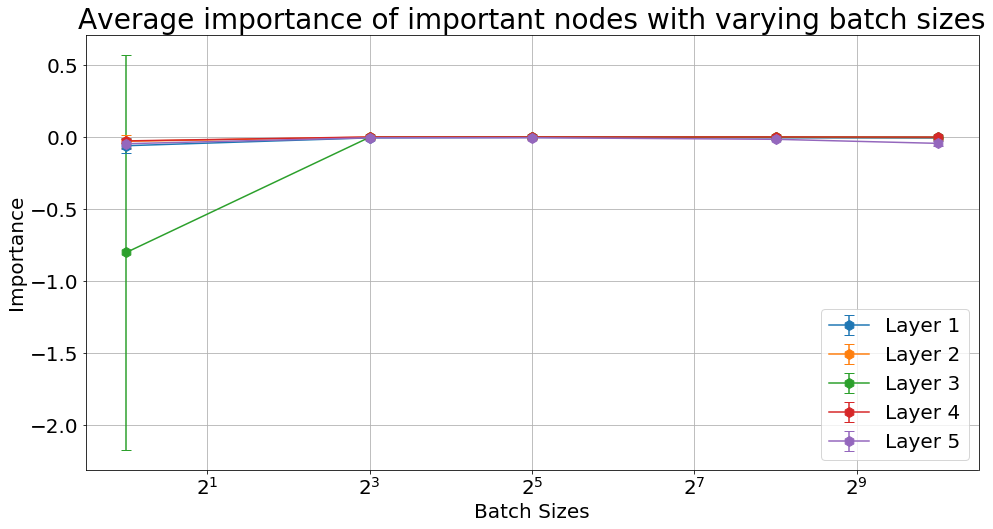

In [68]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_4 = AvgNI_4.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_4 = AvgNI_4.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_5 = AvgNI_5.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_5 = AvgNI_5.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.errorbar(x=batch_sizes, y=m_4, yerr=std_4, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 4')
plt.errorbar(x=batch_sizes, y=m_5, yerr=std_5, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 5')
plt.legend(fontsize=20)
plt.title("Average importance of important nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/avg_imp_nodes_CNN_batch_fmnist.png")

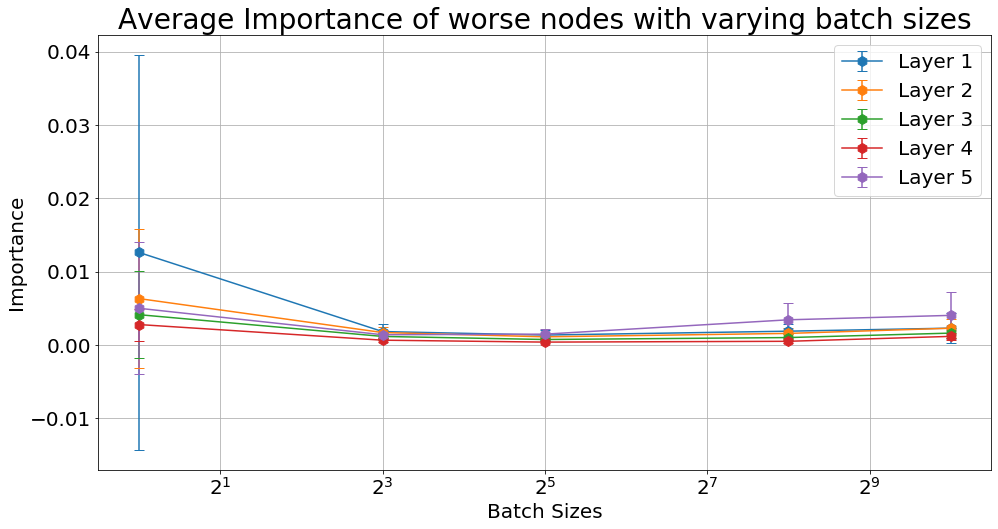

In [69]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_4 = AvgNI_4.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_4 = AvgNI_4.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_5 = AvgNI_5.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_5 = AvgNI_5.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.errorbar(x=batch_sizes, y=m_4, yerr=std_4, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 4')
plt.errorbar(x=batch_sizes, y=m_5, yerr=std_5, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 5')
plt.legend(fontsize=20)
plt.title("Average Importance of worse nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/avg_worse_nodes_CNN_batch_fmnist.png")

## CIFAR10

## Set seed

In [79]:
np.random.seed(2020)

In [80]:
cifar = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [81]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [82]:
trials = 15
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [64, 256, 128, 64, 32]
batch_sizes = [1, 8, 32, 256, 1024]
node_importance = np.zeros((trials, len(batch_sizes), len(layer_sizes), 3))
avg_node_imp = np.zeros((trials, len(batch_sizes), len(layer_sizes), 3))
accs = np.zeros((trials, len(batch_sizes)))
losses = np.zeros((trials, len(batch_sizes)))
for b, batch_size in enumerate(batch_sizes):
    reset_keras()
    for trial in tqdm.trange(trials):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
            ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(x_train, y_train, batch_size=batch_size, verbose=0, epochs=5)
        losses[trial, b], accs[trial, b] = model.evaluate(x_test, y_test, verbose=0)
        tmp_a, _, ai, az, aw = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
        for i, (nz, nw, ni) in enumerate(tmp_a):
            node_importance[trial, b, i, 0] = nz
            node_importance[trial, b, i, 1] = nw
            node_importance[trial, b, i, 2] = ni
            avg_node_imp[trial, b, i] = [az[i], aw[i], ai[i]]

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

22000
0


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

43948
0


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

49761
0


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

43967
0


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

47586
0


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [25:35<00:00, 102.40s/it]


In [83]:
index = pd.MultiIndex.from_product([batch_sizes, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])

In [84]:
NI_1 = pd.DataFrame(node_importance[:, :, 4, :].reshape(trials, -1), columns=index)
NI_1.to_csv('../../../results/node_imp_CNN_l1_batch_cifar.csv')
NI_1.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  15.000000   15.000000       15.000000  15.000000   15.000000   
mean   31.133333    0.066667        0.800000  10.400000    3.000000   
std     2.294922    0.258199        2.111195   2.772312    2.203893   
min    25.000000    0.000000        0.000000   6.000000    0.000000   
25%    32.000000    0.000000        0.000000   9.000000    1.500000   
50%    32.000000    0.000000        0.000000  10.000000    3.000000   
75%    32.000000    0.000000        0.000000  12.500000    3.500000   
max    32.000000    1.000000        6.000000  15.000000    8.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       15.000000  15.000000   15.000000       15.000000  15.000000   
mean        18.600000   1.866667    6.066667       24.066667   0.400000   
std          2.667262   1.060099    2.016598        2.086236   0.736788   
min         15.000000   0.000000    2.000000       20.000000   0.000000   
25%         17.000000   1.000000    5.000000       23.500000   0.000000   
50%         18.000000   2.000000    6.000000       24.000000   0.000000   
75%         20.500000   2.500000    7.000000       25.000000   0.500000   
max         24.000000   4.000000   10.000000       28.000000   2.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  15.000000   15.000000       15.000000  
mean     9.866667       21.733333   0.200000    4.133333       27.666667  
std      4.673125        4.317186   0.414039    3.907258        3.921856  
min      2.000000       14.000000   0.000000    0.000000       21.000000  
25%      7.500000       19.500000   0.000000    1.000000       25.000000  
50%     10.000000       22.000000   0.000000    4.000000       28.000000  
75%     12.500000       23.500000   0.000000    7.000000       31.000000  
max     18.000000       29.000000   1.000000   10.000000       32.000000

In [85]:
AvgNI_1 = pd.DataFrame(avg_node_imp[:, :, 4, :].reshape(trials, -1), columns=index)
AvgNI_1.to_csv('../../../results/avg_node_imp_CNN_l1_batch_cifar.csv')
AvgNI_1.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  1.500000e+01   15.000000       15.000000  1.500000e+01   15.000000   
mean  -1.490116e-09    0.000401       -0.046735  9.262026e-08    0.001321   
std    5.771195e-09    0.001551        0.123463  6.959080e-07    0.001765   
min   -2.235174e-08    0.000000       -0.365403 -1.692772e-06    0.000000   
25%    0.000000e+00    0.000000        0.000000 -2.483527e-09    0.000286   
50%    0.000000e+00    0.000000        0.000000  5.960464e-08    0.000976   
75%    0.000000e+00    0.000000        0.000000  4.236187e-07    0.001311   
max    0.000000e+00    0.006008        0.000000  1.105997e-06    0.007098   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       15.000000  1.500000e+01   15.000000       15.000000  1.500000e+01   
mean        -0.071107 -5.629328e-09    0.004802       -0.034066  4.967054e-07   
std          0.020459  1.483513e-06    0.003626        0.007117  1.686727e-06   
min         -0.108915 -3.874302e-06    0.000955       -0.049191  0.000000e+00   
25%         -0.086743 -1.490116e-08    0.002265       -0.038662  0.000000e+00   
50%         -0.069979  0.000000e+00    0.004158       -0.032207  0.000000e+00   
75%         -0.057520  6.953875e-08    0.005511       -0.029784  0.000000e+00   
max         -0.032811  3.397465e-06    0.014672       -0.023838  6.556511e-06   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  1.500000e+01   15.000000       15.000000  
mean     0.085621       -0.138468  7.947286e-09    0.006077       -0.100726  
std      0.135245        0.149818  3.077971e-08    0.004849        0.029921  
min      0.007911       -0.655247  0.000000e+00    0.000000       -0.164297  
25%      0.019100       -0.142892  0.000000e+00    0.002540       -0.118541  
50%      0.038864       -0.086684  0.000000e+00    0.005048       -0.095597  
75%      0.062580       -0.068342  0.000000e+00    0.009155       -0.079323  
max      0.492668       -0.060780  1.192093e-07    0.015025       -0.058224

In [86]:
NI_2 = pd.DataFrame(node_importance[:, :, 3, :].reshape(trials, -1), columns=index)
NI_2.to_csv('../../../results/node_imp_CNN_l2_batch_cifar.csv')
NI_2.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  15.000000   15.000000       15.000000  15.000000   15.000000   
mean   61.400000    0.333333        2.266667  20.866667    7.133333   
std     6.863985    0.899735        5.993647   3.943651    3.419830   
min    44.000000    0.000000        0.000000  12.000000    2.000000   
25%    64.000000    0.000000        0.000000  20.000000    4.000000   
50%    64.000000    0.000000        0.000000  20.000000    8.000000   
75%    64.000000    0.000000        0.000000  23.000000    8.000000   
max    64.000000    3.000000       18.000000  26.000000   14.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       15.000000  15.000000   15.000000       15.000000  15.000000   
mean        36.000000   8.266667   13.533333       42.200000   2.666667   
std          4.884377   3.555010    5.902380        6.096838   1.496026   
min         28.000000   5.000000    5.000000       31.000000   1.000000   
25%         31.000000   5.500000   10.000000       38.000000   1.500000   
50%         37.000000   7.000000   12.000000       43.000000   2.000000   
75%         39.500000   9.500000   15.500000       47.000000   4.000000   
max         44.000000  16.000000   28.000000       51.000000   5.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  15.000000   15.000000       15.000000  
mean    21.066667       40.266667   0.533333   16.800000       46.666667  
std      3.534860        3.534860   1.060099    3.764496        4.047339  
min     15.000000       36.000000   0.000000    7.000000       40.000000  
25%     18.000000       37.000000   0.000000   14.500000       44.000000  
50%     22.000000       39.000000   0.000000   18.000000       45.000000  
75%     23.500000       43.000000   0.500000   19.500000       49.500000  
max     26.000000       46.000000   3.000000   21.000000       56.000000

In [87]:
AvgNI_2 = pd.DataFrame(avg_node_imp[:, :, 3, :].reshape(trials, -1), columns=index)
AvgNI_2.to_csv('../../../results/avg_node_imp_CNN_l2_batch_cifar.csv')
AvgNI_2.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  1.500000e+01   15.000000       15.000000  1.500000e+01   15.000000   
mean   5.298191e-10    0.001137       -0.007824  7.375161e-09    0.004254   
std    2.051980e-09    0.003408        0.020648  1.244782e-07    0.002847   
min    0.000000e+00    0.000000       -0.058745 -3.622128e-07    0.000788   
25%    0.000000e+00    0.000000        0.000000  0.000000e+00    0.002214   
50%    0.000000e+00    0.000000        0.000000  0.000000e+00    0.003558   
75%    0.000000e+00    0.000000        0.000000  1.464201e-08    0.005580   
max    7.947286e-09    0.012799        0.000000  1.891800e-07    0.010399   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       15.000000  1.500000e+01   15.000000       15.000000  1.500000e+01   
mean        -0.017990  4.022867e-08    0.006748       -0.013076  2.473593e-07   
std          0.004421  3.537985e-07    0.003156        0.002118  1.293373e-06   
min         -0.025294 -5.089320e-07    0.001613       -0.018281 -1.251698e-06   
25%         -0.021096  0.000000e+00    0.004935       -0.013540  0.000000e+00   
50%         -0.016045  0.000000e+00    0.007110       -0.013190  0.000000e+00   
75%         -0.014445  0.000000e+00    0.008776       -0.011890  1.490116e-08   
max         -0.012958  1.226153e-06    0.012956       -0.010093  4.768372e-06   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  1.500000e+01   15.000000       15.000000  
mean     0.056553       -0.045683 -2.357695e-07    0.007711       -0.018985  
std      0.080181        0.037727  7.552112e-07    0.004800        0.004293  
min      0.009138       -0.134922 -2.900759e-06    0.001304       -0.030110  
25%      0.017482       -0.047302  0.000000e+00    0.004249       -0.020856  
50%      0.022546       -0.033737  0.000000e+00    0.006758       -0.017665  
75%      0.041160       -0.023192  0.000000e+00    0.010179       -0.016180  
max      0.283379       -0.014841  0.000000e+00    0.017172       -0.015005

In [88]:
NI_3 = pd.DataFrame(node_importance[:, :, 2, :].reshape(trials, -1), columns=index)
NI_3.to_csv('../../../results/node_imp_CNN_l3_batch_cifar.csv')
NI_3.describe()

1                                      8                 \
       Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count   15.000000   15.000000       15.000000  15.000000   15.000000   
mean   123.266667    1.066667        3.666667  58.533333   13.733333   
std     13.225877    3.390463        9.983319  13.989111    6.540715   
min     81.000000    0.000000        0.000000  29.000000    5.000000   
25%    128.000000    0.000000        0.000000  50.500000   10.500000   
50%    128.000000    0.000000        0.000000  62.000000   12.000000   
75%    128.000000    0.000000        0.000000  69.000000   15.500000   
max    128.000000   13.000000       34.000000  77.000000   29.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       15.000000  15.000000   15.000000       15.000000  15.000000   
mean        55.733333  25.333333   29.866667       72.800000   6.133333   
std         12.623485   7.659417    7.501111        7.921039   2.587516   
min         38.000000  16.000000   15.000000       58.000000   2.000000   
25%         47.000000  19.000000   26.500000       67.000000   4.500000   
50%         56.000000  26.000000   30.000000       74.000000   6.000000   
75%         61.000000  28.500000   32.000000       79.500000   7.000000   
max         86.000000  43.000000   46.000000       86.000000  12.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  15.000000   15.000000       15.000000  
mean    47.866667       74.000000   3.866667   40.200000       83.933333  
std      4.823553        4.225771   1.846490    8.187098        7.591976  
min     41.000000       68.000000   1.000000   27.000000       70.000000  
25%     43.000000       71.000000   3.000000   33.500000       78.000000  
50%     50.000000       74.000000   4.000000   41.000000       84.000000  
75%     52.000000       76.500000   4.500000   46.000000       90.500000  
max     54.000000       82.000000   8.000000   55.000000       97.000000

In [89]:
AvgNI_3 = pd.DataFrame(avg_node_imp[:, :, 2, :].reshape(trials, -1), columns=index)
AvgNI_3.to_csv('../../../results/avg_node_imp_CNN_l3_batch_cifar.csv')
AvgNI_3.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  1.500000e+01   15.000000       15.000000  1.500000e+01   15.000000   
mean   1.522440e-08    0.001132       -0.007981 -1.105872e-08    0.002477   
std    5.774387e-08    0.003538        0.023467  1.783546e-07    0.002308   
min   -4.656613e-08    0.000000       -0.087243 -3.335769e-07    0.000392   
25%    0.000000e+00    0.000000        0.000000 -1.183395e-07    0.000863   
50%    0.000000e+00    0.000000        0.000000 -5.245209e-08    0.001622   
75%    9.313226e-10    0.000000        0.000000  9.654854e-08    0.003302   
max    2.104559e-07    0.013504        0.000000  3.187193e-07    0.007512   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       15.000000  1.500000e+01   15.000000       15.000000  1.500000e+01   
mean        -0.011007 -7.289302e-08    0.004126       -0.006292 -2.699239e-08   
std          0.003856  2.282257e-07    0.001825        0.001392  4.434999e-07   
min         -0.018570 -6.098014e-07    0.002352       -0.010345 -1.379422e-06   
25%         -0.012442 -1.582383e-07    0.003075       -0.006653  0.000000e+00   
50%         -0.010635 -9.097551e-08    0.003799       -0.006046  0.000000e+00   
75%         -0.008080  1.350929e-08    0.004596       -0.005378  1.341105e-08   
max         -0.004828  3.819112e-07    0.009808       -0.004781  9.139379e-07   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  1.500000e+01   15.000000       15.000000  
mean     0.026807       -0.014804  4.431936e-07    0.003976       -0.005738  
std      0.036130        0.011413  1.817599e-06    0.002112        0.001543  
min      0.002871       -0.044903 -1.335144e-06    0.001529       -0.008912  
25%      0.007859       -0.016093 -8.940697e-08    0.002799       -0.006464  
50%      0.012792       -0.010327  0.000000e+00    0.003454       -0.005193  
75%      0.023230       -0.008295  3.973643e-08    0.004801       -0.004827  
max      0.122323       -0.005039  6.318092e-06    0.009511       -0.003837

In [90]:
NI_4 = pd.DataFrame(node_importance[:, :, 1, :].reshape(trials, -1), columns=index)
NI_4.to_csv('../../../results/node_imp_CNN_l4_batch_cifar.csv')
NI_4.describe()

1                                       8                 \
       Zero Nodes Worse Nodes Important Nodes  Zero Nodes Worse Nodes   
count   15.000000   15.000000       15.000000   15.000000   15.000000   
mean   248.066667    2.666667        5.266667  103.333333   60.533333   
std     20.592879    7.016986       13.656326   18.775617   13.324878   
min    187.000000    0.000000        0.000000   71.000000   44.000000   
25%    255.000000    0.000000        0.000000   89.000000   47.500000   
50%    256.000000    0.000000        0.000000  104.000000   62.000000   
75%    256.000000    0.500000        0.500000  117.500000   70.500000   
max    256.000000   25.000000       44.000000  140.000000   82.000000   

                             32                                     256   \
      Important Nodes  Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       15.000000   15.000000   15.000000       15.000000  15.000000   
mean        92.133333   81.733333   80.866667       93.400000  46.066667   
std         12.811082   13.535491   13.032195       11.350267   6.818742   
min         72.000000   56.000000   59.000000       71.000000  37.000000   
25%         87.000000   74.500000   70.000000       84.000000  41.500000   
50%         90.000000   80.000000   83.000000       95.000000  45.000000   
75%         92.500000   88.000000   89.500000      101.000000  48.000000   
max        123.000000  112.000000  106.000000      114.000000  64.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  15.000000   15.000000       15.000000  
mean    99.466667      110.466667  32.600000   80.733333      142.666667  
std     10.398260        8.450416   7.908404    9.844989       13.589211  
min     83.000000       95.000000  18.000000   67.000000      117.000000  
25%     92.000000      105.500000  28.500000   74.000000      132.500000  
50%     99.000000      109.000000  34.000000   80.000000      144.000000  
75%    109.500000      117.500000  38.500000   89.000000      153.000000  
max    113.000000      123.000000  45.000000   99.000000      164.000000

In [91]:
AvgNI_4 = pd.DataFrame(avg_node_imp[:, :, 1, :].reshape(trials, -1), columns=index)
AvgNI_4.to_csv('../../../results/avg_node_imp_CNN_l4_batch_cifar.csv')
AvgNI_4.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  1.500000e+01   15.000000       15.000000  1.500000e+01   15.000000   
mean  -1.650372e-09    0.000386       -0.001391 -5.518324e-08    0.001641   
std    8.083229e-09    0.000981        0.003701  1.239836e-07    0.000789   
min   -3.059918e-08    0.000000       -0.011907 -3.397465e-07    0.000486   
25%    0.000000e+00    0.000000       -0.000013 -1.188029e-07    0.001093   
50%    0.000000e+00    0.000000        0.000000 -2.980232e-08    0.001285   
75%    0.000000e+00    0.000028        0.000000  2.338336e-08    0.002076   
max    3.973643e-09    0.003370        0.000000  1.261401e-07    0.003176   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       15.000000  1.500000e+01   15.000000       15.000000  1.500000e+01   
mean        -0.001926 -3.617287e-08    0.001926       -0.001654 -8.878592e-08   
std          0.000413  1.204301e-07    0.000535        0.000293  1.142796e-07   
min         -0.002874 -2.176574e-07    0.001017       -0.002131 -3.240047e-07   
25%         -0.002172 -1.326546e-07    0.001576       -0.001833 -1.522884e-07   
50%         -0.001892 -4.576785e-08    0.001949       -0.001707 -4.470348e-08   
75%         -0.001634  4.859533e-08    0.002284       -0.001461 -1.303852e-08   
max         -0.001351  1.606418e-07    0.002814       -0.001181  6.311080e-08   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  1.500000e+01   15.000000       15.000000  
mean     0.008830       -0.003545 -1.467266e-08    0.001507       -0.001873  
std      0.011430        0.002137  1.730053e-07    0.000603        0.000489  
min      0.001761       -0.008842 -4.072984e-07    0.000661       -0.002923  
25%      0.003071       -0.003782 -9.852297e-08    0.001098       -0.002179  
50%      0.004390       -0.002672  8.514949e-09    0.001365       -0.001788  
75%      0.007200       -0.002261  9.255042e-08    0.001853       -0.001471  
max      0.038887       -0.001737  2.715323e-07    0.002652       -0.001301

In [92]:
NI_5 = pd.DataFrame(node_importance[:, :, 0, :].reshape(trials, -1), columns=index)
NI_5.to_csv('../../../results/node_imp_CNN_l5_batch_cifar.csv')
NI_5.describe()

1                                      8                 \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  15.000000   15.000000       15.000000  15.000000   15.000000   
mean   60.733333    0.733333        2.533333  36.400000    7.066667   
std     8.639334    2.153624        6.696125   5.500649    4.061433   
min    38.000000    0.000000        0.000000  22.000000    3.000000   
25%    64.000000    0.000000        0.000000  33.000000    5.000000   
50%    64.000000    0.000000        0.000000  38.000000    6.000000   
75%    64.000000    0.000000        0.000000  40.000000    8.000000   
max    64.000000    8.000000       20.000000  43.000000   20.000000   

                            32                                     256   \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       15.000000  15.000000   15.000000       15.000000  15.000000   
mean        20.533333  43.133333    2.800000       18.066667  37.000000   
std          3.700708   4.373078    2.210365        2.890049   4.825527   
min         16.000000  36.000000    0.000000       12.000000  31.000000   
25%         17.000000  41.000000    1.000000       16.000000  33.000000   
50%         21.000000  43.000000    2.000000       18.000000  37.000000   
75%         23.500000  45.500000    4.000000       20.000000  38.500000   
max         26.000000  52.000000    7.000000       22.000000  46.000000   

                                        1024                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  15.000000   15.000000       15.000000  
mean     5.200000       21.800000  35.733333    1.133333       27.133333  
std      3.028437        3.913347   4.651677    1.457330        3.925497  
min      1.000000       15.000000  26.000000    0.000000       22.000000  
25%      3.500000       19.000000  33.000000    0.000000       24.500000  
50%      4.000000       22.000000  38.000000    1.000000       26.000000  
75%      7.000000       23.500000  39.000000    1.500000       30.000000  
max     11.000000       29.000000  42.000000    4.000000       34.000000

In [93]:
AvgNI_5 = pd.DataFrame(avg_node_imp[:, :, 0, :].reshape(trials, -1), columns=index)
AvgNI_5.to_csv('../../../results/avg_node_imp_CNN_l5_batch_cifar.csv')
AvgNI_5.describe()

1                                         8                 \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  1.500000e+01   15.000000       15.000000  1.500000e+01   15.000000   
mean   4.085864e-09    0.000305       -0.004500 -3.570315e-08    0.001290   
std    8.044305e-08    0.001050        0.011971  1.503763e-07    0.001015   
min   -1.802677e-07    0.000000       -0.037749 -3.172505e-07    0.000134   
25%    0.000000e+00    0.000000        0.000000 -1.717844e-07    0.000522   
50%    0.000000e+00    0.000000        0.000000  0.000000e+00    0.000739   
75%    0.000000e+00    0.000000        0.000000  5.114555e-08    0.001776   
max    2.415557e-07    0.004071        0.000000  2.036492e-07    0.003136   

                               32                                        256   \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       15.000000  1.500000e+01   15.000000       15.000000  1.500000e+01   
mean        -0.065123 -4.664182e-08    0.002614       -0.116841 -4.965660e-09   
std          0.037829  1.445178e-07    0.004166        0.060068  1.870657e-08   
min         -0.154747 -2.259432e-07    0.000000       -0.270740 -7.256218e-08   
25%         -0.088670 -1.787804e-07    0.000153       -0.134794  0.000000e+00   
50%         -0.050704 -4.146410e-08    0.000652       -0.106280  0.000000e+00   
75%         -0.039121  6.355282e-09    0.002878       -0.072282  0.000000e+00   
max         -0.023972  2.172258e-07    0.014434       -0.052024  0.000000e+00   

                                           1024                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   15.000000       15.000000  1.500000e+01   15.000000       15.000000  
mean     0.072069       -0.132085  9.128539e-09    0.003953       -0.102567  
std      0.115324        0.074064  5.228463e-08    0.005710        0.034882  
min      0.007162       -0.273440 -3.667978e-08    0.000000       -0.146683  
25%      0.018220       -0.172255  0.000000e+00    0.000000       -0.134485  
50%      0.033070       -0.101076  0.000000e+00    0.000994       -0.115599  
75%      0.045180       -0.079047  0.000000e+00    0.006076       -0.068237  
max      0.370506       -0.052039  1.937151e-07    0.021265       -0.057025

In [94]:
A = pd.DataFrame(accs, columns=batch_sizes)
A.to_csv('../../../results/acc_CNN_batch_cifar.csv')
A.describe()

,1,8,32,256,1024
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.159247,0.688253,0.722247,0.575700,0.573640
std,0.156368,0.017025,0.009825,0.113001,0.013789
min,0.100000,0.646100,0.705000,0.292500,0.542000
25%,0.100000,0.682700,0.716350,0.570100,0.566900
50%,0.100000,0.690900,0.723900,0.615100,0.572000
75%,0.100000,0.700800,0.728600,0.638100,0.583400
max,0.550300,0.709700,0.736400,0.659500,0.597000


In [95]:
L = pd.DataFrame(losses, columns=batch_sizes)
L.to_csv('../../../results/loss_CNN_batch_cifar.csv')
L.describe()

,1,8,32,256,1024
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,2.169682,0.928494,0.828927,1.444166,1.197288
std,0.352519,0.055734,0.031057,0.897529,0.034675
min,1.289457,0.870939,0.775216,0.967459,1.146907
25%,2.303025,0.887790,0.809387,1.027506,1.175964
50%,2.303121,0.923276,0.835000,1.094505,1.199314
75%,2.303346,0.933757,0.846029,1.294669,1.211220
max,2.303788,1.083468,0.878676,4.043875,1.274844


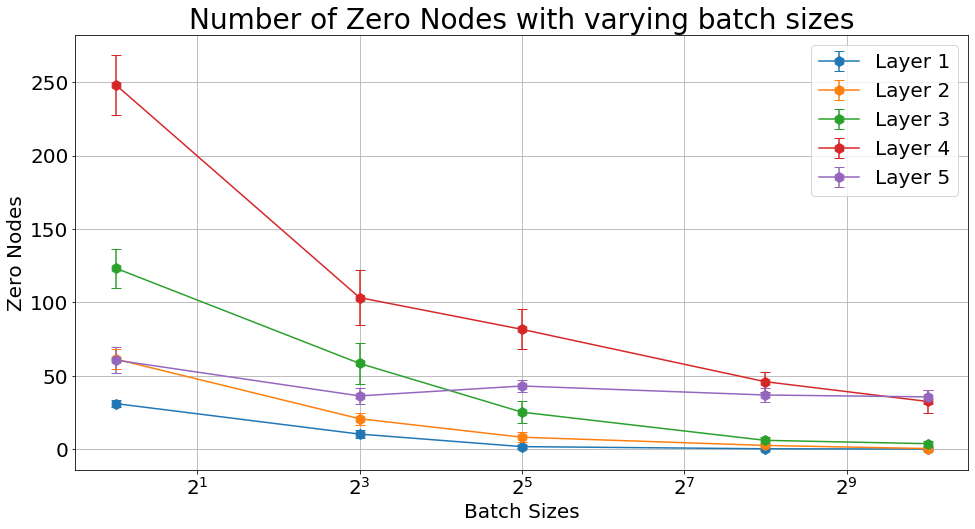

In [101]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_4 = NI_4.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_4 = NI_4.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_5 = NI_5.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_5 = NI_5.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.errorbar(x=batch_sizes, y=m_4, yerr=std_4, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 4')
plt.errorbar(x=batch_sizes, y=m_5, yerr=std_5, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 5')
plt.legend(fontsize=20)
plt.title("Number of Zero Nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Zero Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/zero_nodes_CNN_batch_cifar.png")

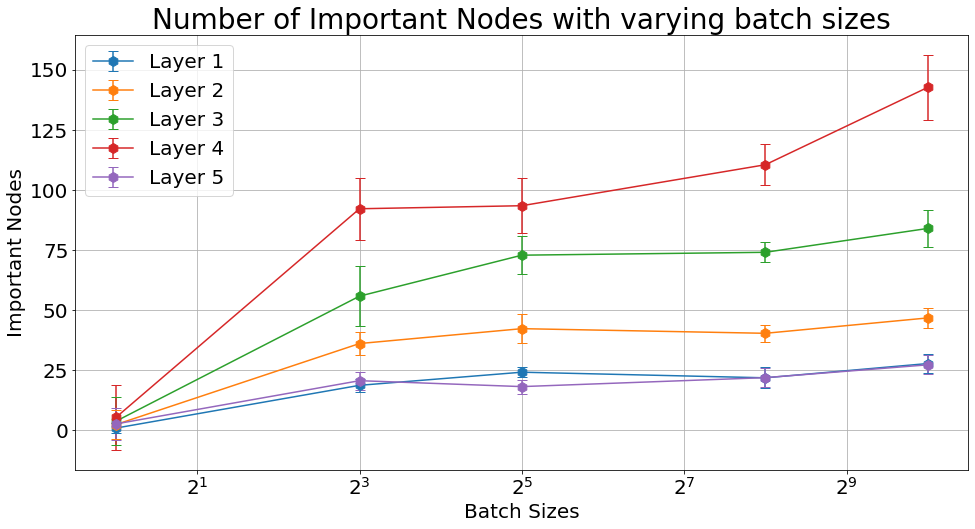

In [102]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_4 = NI_4.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_4 = NI_4.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_5 = NI_5.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_5 = NI_5.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.errorbar(x=batch_sizes, y=m_4, yerr=std_4, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 4')
plt.errorbar(x=batch_sizes, y=m_5, yerr=std_5, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 5')
plt.legend(fontsize=20)
plt.title("Number of Important Nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Important Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/imp_nodes_CNN_batch_cifar.png")

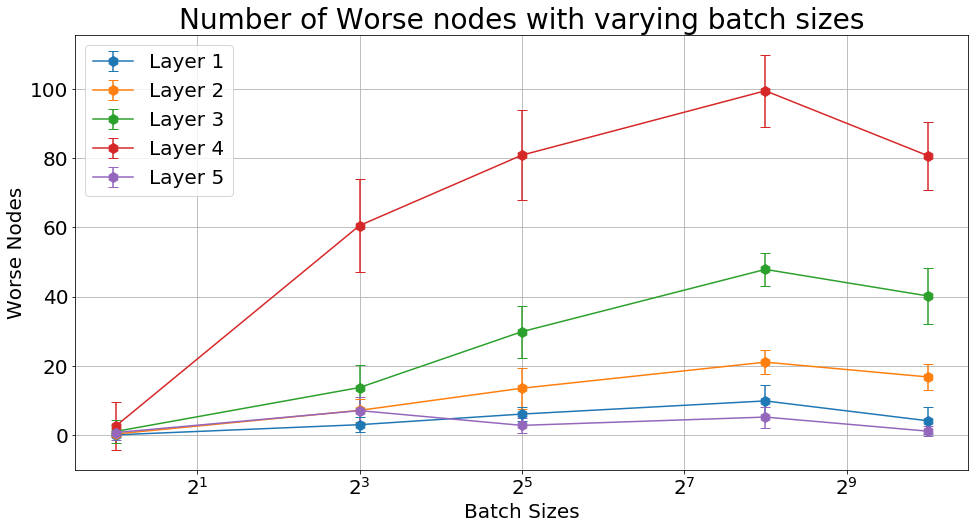

In [103]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_4 = NI_4.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_4 = NI_4.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_5 = NI_5.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_5 = NI_5.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.errorbar(x=batch_sizes, y=m_4, yerr=std_4, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 4')
plt.errorbar(x=batch_sizes, y=m_5, yerr=std_5, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 5')
plt.legend(fontsize=20)
plt.title("Number of Worse nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Worse Nodes", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/worse_nodes_CNN_batch_cifar.png")

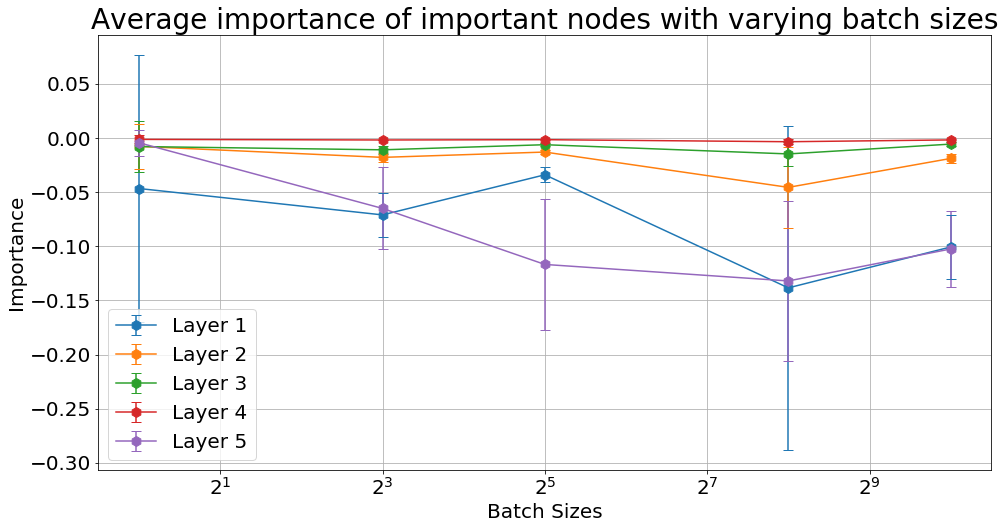

In [104]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_4 = AvgNI_4.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_4 = AvgNI_4.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_5 = AvgNI_5.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_5 = AvgNI_5.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.errorbar(x=batch_sizes, y=m_4, yerr=std_4, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 4')
plt.errorbar(x=batch_sizes, y=m_5, yerr=std_5, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 5')
plt.legend(fontsize=20)
plt.title("Average importance of important nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/avg_imp_nodes_CNN_batch_cifar.png")

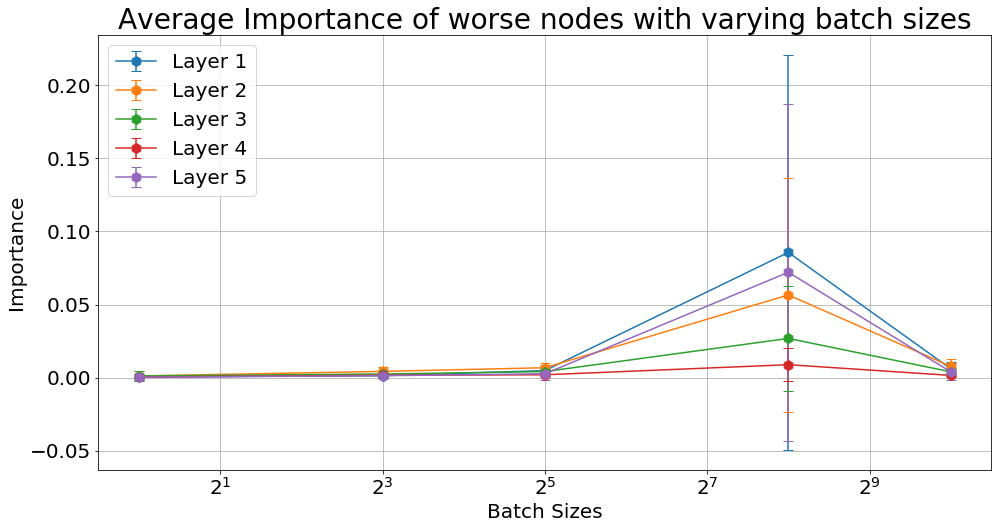

In [105]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_4 = AvgNI_4.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_4 = AvgNI_4.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_5 = AvgNI_5.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_5 = AvgNI_5.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=batch_sizes, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=batch_sizes, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=batch_sizes, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.errorbar(x=batch_sizes, y=m_4, yerr=std_4, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 4')
plt.errorbar(x=batch_sizes, y=m_5, yerr=std_5, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 5')
plt.legend(fontsize=20)
plt.title("Average Importance of worse nodes with varying batch sizes", size=28)
plt.xlabel("Batch Sizes", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
ax.set_xscale('log', basex=2)
plt.grid(True)
plt.savefig("../../../figures/avg_worse_nodes_CNN_batch_cifar.png")